In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 70%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 90%; }
</style>
"""))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn import metrics
from sklearn.metrics import roc_auc_score,accuracy_score
import random
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from multiprocessing.pool import Pool # 进程池
from utils import *

In [5]:
# dataset_list = ['assist2009','algebra2005','bridge2algebra2006','nips_task34','peiyou','ednet']
dataset_list = ['algebra2005','peiyou','ednet']
model_list = ['iekt','qdkt','akt']
model_root_dir = "/mnt/cfs/project2/full_result_pykt/best_model_path"

## 读取原始的预测结果

In [6]:
# df_dict存放题目预测概率， report_list存放auc和acc
df_dict_raw,report_list_raw = load_pred_result(model_list,dataset_list,model_root_dir)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
df_report = pd.DataFrame(report_list_raw)
df_report['auc+std'] = df_report.apply(lambda x:f"{x['auc']:>.4f}±{x['std']:>.4f}",axis=1)
df_pivot = pd.pivot_table(df_report,index=['model_name'],columns=['dataset'],values=['auc+std'],aggfunc=sum,sort=False).fillna("-")['auc+std']
df_pivot

dataset       algebra2005         peiyou          ednet
model_name                                             
iekt        0.8416±0.0014  0.8280±0.0002  0.7335±0.0014
qdkt        0.7485±0.0017  0.8225±0.0002  0.6987±0.0010
akt         0.8306±0.0019  0.8207±0.0008  0.6721±0.0022

In [8]:
num_repeat = 10

In [9]:
# 每个数据集第一个fold随机抽样10000 samples，循环抽十次
df_dict,report_list = sample_dataset(model_list,dataset_list,df_dict_raw,num_repeat=num_repeat,num_sample=10000)

In [10]:
df_report = pd.DataFrame(report_list)
df_report['auc+std'] = df_report.apply(lambda x:f"{x['auc']:>.4f}±{x['std']:>.4f}",axis=1)
df_pivot = pd.pivot_table(df_report,index=['model_name'],columns=['dataset'],values=['auc+std'],aggfunc=sum,sort=False).fillna("-")['auc+std']
df_pivot

dataset       algebra2005         peiyou          ednet
model_name                                             
iekt        0.8407±0.0035  0.8290±0.0035  0.7323±0.0056
qdkt        0.7540±0.0064  0.8236±0.0039  0.6973±0.0054
akt         0.8310±0.0041  0.8235±0.0036  0.6689±0.0037

In [11]:
len(df_dict_raw),len(df_dict)

(45, 90)

In [20]:
df_dict

{'algebra2005_iekt_0':          y_pred  y_true  uid  inter_num  late_mean
 7110   0.880310       1   15       3182   0.880310
 64997  0.743185       1  423        694   0.743185
 43385  0.934006       1  439        604   0.934006
 28465  0.982068       1  195       3637   0.982068
 81257  0.946325       1  182       1924   0.946325
 ...         ...     ...  ...        ...        ...
 40611  0.323579       0  120       3225   0.323579
 62055  0.971373       1   80       3965   0.971373
 2696   0.716934       1  257        701   0.716934
 87790  0.967309       1  171       2135   0.967309
 4640   0.999963       1  322        762   0.999963
 
 [10000 rows x 5 columns],
 'algebra2005_iekt_1':          y_pred  y_true  uid  inter_num  late_mean
 20696  0.429560       1  446        676   0.429560
 60617  0.487936       0   80       3965   0.487936
 83122  0.459781       1   48       1029   0.459781
 74725  0.354713       1  144       2815   0.354713
 53102  0.895225       1  163       2126   

In [12]:
#确保数据没问题
data_report_list = []
for dataset in dataset_list:
    for model_name in model_list:
        for repeat_index in range(num_repeat):
            df_sample = df_dict[f'{dataset}_{model_name}_{repeat_index}']
            data_report = get_metrics(df_sample['y_true'],df_sample['y_pred'])
            data_report['model_name'] = model_name
            data_report['dataset'] = dataset
            data_report_list.append(data_report)

In [13]:
df_data_report = pd.DataFrame(data_report_list)

In [14]:
df_data_report.groupby(['dataset','model_name']).mean()

acc       auc
dataset     model_name                   
algebra2005 akt         0.81390  0.831013
            iekt        0.82191  0.840718
            qdkt        0.72716  0.753988
ednet       akt         0.66760  0.668871
            iekt        0.71249  0.732255
            qdkt        0.69293  0.697308
peiyou      akt         0.82622  0.823486
            iekt        0.83071  0.828994
            qdkt        0.82883  0.823632

## 数据统计

In [15]:
# 确保数据没问题
data_report_list = []
for dataset in dataset_list:
    for model_name in model_list:
        model_report = {"model_name": model_name, "dataset": dataset}
        acc_list = []
        auc_list = []
        pos_rate_list = []
        df_sample_list = []
        for repeat_index in range(num_repeat):
            df_sample = df_dict[f'{dataset}_{model_name}_{repeat_index}']
            pos_rate_list.append(df_sample['y_true'].mean())
            data_report = get_metrics(df_sample['y_true'], df_sample['y_pred'])
            acc_list.append(data_report['acc'])
            auc_list.append(data_report['auc'])
            df_sample_list.append(df_sample)
        df_sample_merge = pd.concat(df_sample_list).drop_duplicates(
            ['qidx', 'questions', 'concepts', 'concept_preds', 'late_mean', 'y_pred'])
        model_report['Accuracy'] = f"{np.mean(acc_list):.4f}±{np.std(acc_list):.4f}"
        model_report['AUC'] = f"{np.mean(auc_list):.4f}±{np.std(auc_list):.4f}"
        model_report['Percent of positive interactions'] = f"{np.mean(pos_rate_list):.4f}±{np.std(pos_rate_list):.4f}"
        model_report['Total unique interactions'] = len(df_sample_merge)
        data_report_list.append(model_report)
#         break
#     break

KeyError: Index(['concept_preds', 'questions', 'concepts', 'qidx'], dtype='object')

In [16]:
df_data_report = pd.DataFrame(data_report_list)
df_data_report

Empty DataFrame
Columns: []
Index: []

In [17]:
df_pivot = pd.pivot_table(df_data_report, index=['dataset'], columns=[
                          'model_name'], aggfunc=lambda x: "".join([str(i) for i in x]), sort=False)
df_pivot

KeyError: 'dataset'

In [18]:
df_data_report

Empty DataFrame
Columns: []
Index: []

In [19]:
data_report

{'acc': 0.8155, 'auc': 0.8343075971820861}

## 置信度计算方法

### 基于概率

In [21]:
human_type_config = {"S": {
    "human_cost": 5,
    "human_correct_rate": 0.97,
    'human_level': "S"
}, "A": {
    "human_cost": 1,
    "human_correct_rate": 0.90,
    "human_level": "A"
}}

model_cost = 0.01
num_repeat = 10

In [22]:
# 模拟human scoring
human_dict = {}
for dataset in tqdm(dataset_list):
    for model_name in model_list:
        for repeat_index in range(num_repeat):
            y_true = df_dict[f'{dataset}_{model_name}_{repeat_index}']['y_true'].values
            for human_type in human_type_config.keys():
                # 按照占比采样
                human_info = human_type_config[human_type]
                index = np.arange(0, len(y_true))
                mask = np.arange(0, len(y_true))
                np.random.seed(human_info['human_cost']*1000)
                np.random.shuffle(mask)
                mask = mask[:int(
                    human_info['human_correct_rate'] * len(y_true))]
                human_pred = np.where(np.isin(index, mask),
                                      y_true, np.abs(y_true - 1))
                human_dict[f"{dataset}_{model_name}_{repeat_index}_{human_info['human_level']}"] = human_pred
                acc = np.mean(human_pred == y_true)
                print(acc, human_info)

  0%|          | 0/3 [00:00<?, ?it/s]

0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 

In [23]:
min_tau = 0
max_tau = 1.00001
tau_step = 0.05
condition_type = "area_prob"  #area_prob
# condition_type = "class_prob"

In [26]:
input_data_list = []
for dataset in tqdm(dataset_list):
    for model in model_list:  # model
        for repeat_index in range(10):
            for alloc_config in tqdm(alloc_list, leave=False):  # 分配方法
                y_true = df_dict[f'{dataset}_{model}_{repeat_index}']['y_true'].values
                model_pred = df_dict[f'{dataset}_{model}_{repeat_index}']['y_pred'].values
                # 计算不同的tau
                for tau in np.arange(min_tau, max_tau, tau_step):
                    if condition_type == 'area_prob':  # 按照0.5卡区间
                        condition = (np.abs(model_pred - 0.5) / 0.5) > tau
                    input_data = {"dataset": dataset,
                                  'model_pred': model_pred,
                                  "y_true": y_true,
                                  "repeat_index": repeat_index,
                                  "alloc_config": alloc_config,
                                  "condition": condition,
                                  "model": model,
                                  "tau": tau}
                    input_data_list.append(input_data)
len(input_data_list)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

11340

In [27]:
pd.to_pickle(input_data_list, 'input_data_list.pkl')

### Sample test

In [28]:
input_data_list[0]

{'dataset': 'algebra2005',
 'model_pred': array([0.88031048, 0.74318451, 0.93400604, ..., 0.7169342 , 0.96730942,
        0.99996316]),
 'y_true': array([1, 1, 1, ..., 1, 1, 1]),
 'repeat_index': 0,
 'alloc_config': {'mode': 'S'},
 'condition': array([ True,  True,  True, ...,  True,  True,  True]),
 'model': 'iekt',
 'tau': 0.0}

In [29]:
condition_model = input_data_list[10]["condition"]
print(f"condition_model:{condition_model}")
roles = np.where(condition_model, 0, 1)
print(f"roles:{roles}")
condition_human = ~condition_model
print(f"condition_human:{condition_human}")
human_num = roles.sum()  # human的数量
print(human_num)
keep_index = np.arange(0, len(condition_model))
print(keep_index)
keep_index = keep_index[condition_human]
len(keep_index)

condition_model:[ True False  True ... False  True  True]
roles:[0 1 0 ... 1 0 0]
condition_human:[False  True False ...  True False False]
2779
[   0    1    2 ... 9997 9998 9999]


2779

In [30]:
import numpy as np
model_pred = np.array([0.5,0.9,0.8,0.7,0.5,0.2,0.3])
keep_index = np.array([0,2,4,6])

model_confi = np.abs(model_pred - 0.5) / 0.5
print(model_confi[keep_index])
sort_index1 = np.where( model_confi<0.5 )
sort_index2 = np.where( model_confi>=0.5 )
s_index = np.intersect1d(keep_index, sort_index1)
a_index = np.intersect1d(keep_index, sort_index2)
print(type(s_index),s_index, a_index)
split_index = [ sort_index1, sort_index2 ]
split_index

[0.  0.6 0.  0.4]
<class 'numpy.ndarray'> [0 4 6] [2]


[(array([0, 3, 4, 6]),), (array([1, 2, 5]),)]

### 多线程同时运行函数

In [31]:
alloc_list = [ {"mode": "S"}, {"mode": "A"}, 
                  {"mode": "average"}, {"mode": "conf_average"}, 
                  {"mode": "conf_threshold"}, {"mode": "conf_weight_average"} ]
#     "mode": "conf_average"}, {"mode": "conf_weight_average"}

In [32]:
def get_one_report(input_data, debug=False):
    condition = input_data['condition']
    model_pred = input_data['model_pred']
    dataset = input_data['dataset']
    alloc_config = input_data['alloc_config']
    y_true = input_data['y_true']

    # 分配人类
    human_pred, human_num, roles, human_cost = allocation_humans(
        condition_model=condition,
        model_pred=model_pred,
        model_name=input_data['model'],
        repeat_index=input_data['repeat_index'],
        dataset=dataset,
        config=alloc_config,
        human_type_config=human_type_config,
        human_dict=human_dict,
        debug=debug)

    cost = human_cost + model_cost*(len(model_pred)-human_num)

    y_pred = np.where(condition, model_pred, human_pred)

    report = {
        "dataset": dataset,
        "model": input_data['model'],
        "tau": input_data['tau'],
        "auto_score_cover": 1 - roles.mean(),
        "repeat_index":input_data['repeat_index'],
        "human_num": human_num,
        "cost": cost,
        "alloc_mode": alloc_config['mode']
    }
    report.update(get_metrics(y_true, y_pred))  # 计算AUC占用96%的时间
    human_result = get_metrics(y_true, human_pred, "human_")
    model_result = get_metrics(y_true, model_pred, "model_")
    report.update(human_result)
    report.update(model_result)
    return report

In [33]:
input_data_list = pd.read_pickle("input_data_list.pkl")

In [34]:
%%time
p = Pool()
# 多进程同时运行get_one_report函数
report_list = p.map(get_one_report, input_data_list)
p.close()

CPU times: user 572 ms, sys: 1.82 s, total: 2.39 s
Wall time: 6.1 s


In [37]:
# pool运行不稳定，原始循环运行函数
import time
report_list = []
for i in range(len(input_data_list)):
    begin_time = time.time()
    report = get_one_report(input_data_list[i])
    report_list.append(report)
    print(begin_time)

1693796674.4860582
1693796674.5001426
1693796674.512766
1693796674.5250218
1693796674.5373392
1693796674.5495625
1693796674.5619993
1693796674.574325
1693796674.5899205
1693796674.6026435
1693796674.615109
1693796674.6275847
1693796674.6398144
1693796674.652032
1693796674.6643083
1693796674.676477
1693796674.6885653
1693796674.7021053
1693796674.7142954
1693796674.726123
1693796674.737872
1693796674.7493062
1693796674.7614071
1693796674.7736366
1693796674.7858865
1693796674.7983484
1693796674.8106065
1693796674.82299
1693796674.835284
1693796674.847594
1693796674.859972
1693796674.8722785
1693796674.8845139
1693796674.8967206
1693796674.9093494
1693796674.9215684
1693796674.9355683
1693796674.9481769
1693796674.9602656
1693796674.9722366
1693796674.9840484
1693796674.995785
1693796675.0072832
1693796675.0193434
1693796675.0318968
1693796675.0443313
1693796675.0567865
1693796675.069214
1693796675.0817046
1693796675.0942092
1693796675.1068797
1693796675.1199043
1693796675.1325257
1693796

KeyboardInterrupt: 

In [30]:
1676621770.737979 - 1676621446.5605626

324.1774163246155

In [38]:
df_report = pd.DataFrame(report_list)
#df_report['Model'] = df_report['model'].map(col_map)
df_report.shape

(11340, 14)

In [39]:
df_report[df_report['tau'] == 0.9].head(50)

dataset model  tau  auto_score_cover  repeat_index  human_num  \
18    algebra2005  iekt  0.9            0.2500             0       7500   
39    algebra2005  iekt  0.9            0.2500             0       7500   
60    algebra2005  iekt  0.9            0.2500             0       7500   
81    algebra2005  iekt  0.9            0.2500             0       7500   
102   algebra2005  iekt  0.9            0.2500             0       7500   
123   algebra2005  iekt  0.9            0.2500             0       7500   
144   algebra2005  iekt  0.9            0.2474             1       7526   
165   algebra2005  iekt  0.9            0.2474             1       7526   
186   algebra2005  iekt  0.9            0.2474             1       7526   
207   algebra2005  iekt  0.9            0.2474             1       7526   
228   algebra2005  iekt  0.9            0.2474             1       7526   
249   algebra2005  iekt  0.9            0.2474             1       7526   
270   algebra2005  iekt  0.9            0.2428             2       7572   
291   algebra2005  iekt  0.9            0.2428             2       7572   
312   algebra2005  iekt  0.9            0.2428             2       7572   
333   algebra2005  iekt  0.9            0.2428             2       7572   
354   algebra2005  iekt  0.9            0.2428             2       7572   
375   algebra2005  iekt  0.9            0.2428             2       7572   
396   algebra2005  iekt  0.9            0.2487             3       7513   
417   algebra2005  iekt  0.9            0.2487             3       7513   
438   algebra2005  iekt  0.9            0.2487             3       7513   
459   algebra2005  iekt  0.9            0.2487             3       7513   
480   algebra2005  iekt  0.9            0.2487             3       7513   
501   algebra2005  iekt  0.9            0.2487             3       7513   
522   algebra2005  iekt  0.9            0.2477             4       7523   
543   algebra2005  iekt  0.9            0.2477             4       7523   
564   algebra2005  iekt  0.9            0.2477             4       7523   
585   algebra2005  iekt  0.9            0.2477             4       7523   
606   algebra2005  iekt  0.9            0.2477             4       7523   
627   algebra2005  iekt  0.9            0.2477             4       7523   
648   algebra2005  iekt  0.9            0.2503             5       7497   
669   algebra2005  iekt  0.9            0.2503             5       7497   
690   algebra2005  iekt  0.9            0.2503             5       7497   
711   algebra2005  iekt  0.9            0.2503             5       7497   
732   algebra2005  iekt  0.9            0.2503             5       7497   
753   algebra2005  iekt  0.9            0.2503             5       7497   
774   algebra2005  iekt  0.9            0.2514             6       7486   
795   algebra2005  iekt  0.9            0.2514             6       7486   
816   algebra2005  iekt  0.9            0.2514             6       7486   
837   algebra2005  iekt  0.9            0.2514             6       7486   
858   algebra2005  iekt  0.9            0.2514             6       7486   
879   algebra2005  iekt  0.9            0.2514             6       7486   
900   algebra2005  iekt  0.9            0.2515             7       7485   
921   algebra2005  iekt  0.9            0.2515             7       7485   
942   algebra2005  iekt  0.9            0.2515             7       7485   
963   algebra2005  iekt  0.9            0.2515             7       7485   
984   algebra2005  iekt  0.9            0.2515             7       7485   
1005  algebra2005  iekt  0.9            0.2515             7       7485   
1026  algebra2005  iekt  0.9            0.2540             8       7460   
1047  algebra2005  iekt  0.9            0.2540             8       7460   

          cost           alloc_mode     acc       auc  human_acc  human_auc  \
18    37525.00                    S  0.9693  0.967447     0.9700   0.969562   
39     7525.00            

In [40]:
df_report[df_report['tau'].isin([0.5])].groupby(["dataset","tau","model","alloc_mode"]).mean()

auto_score_cover  repeat_index  \
dataset     tau model alloc_mode                                            
algebra2005 0.5 akt   A                             0.76423           4.5   
                      S                             0.76423           4.5   
                      average                       0.76423           4.5   
                      conf_average                  0.76423           4.5   
                      conf_threshold                0.76423           4.5   
                      conf_weight_average           0.76423           4.5   
                iekt  A                             0.71655           4.5   
                      S                             0.71655           4.5   
                      average                       0.71655           4.5   
                      conf_average                  0.71655           4.5   
                      conf_threshold                0.71655           4.5   
                      conf_weight_average           0.71655           4.5   
                qdkt  A                             0.54736           4.5   
                      S                             0.54736           4.5   
                      average                       0.54736           4.5   
                      conf_average                  0.54736           4.5   
                      conf_threshold                0.54736           4.5   
                      conf_weight_average           0.54736           4.5   
ednet       0.5 akt   A                             0.58638           4.5   
                      S                             0.58638           4.5   
                      average                       0.58638           4.5   
                      conf_average                  0.58638           4.5   
                      conf_threshold                0.58638           4.5   
                      conf_weight_average           0.58638           4.5   
                iekt  A                             0.36896           4.5   
                      S                             0.36896           4.5   
                      average                       0.36896           4.5   
                      conf_average                  0.36896           4.5   
                      conf_threshold                0.36896           4.5   
                      conf_weight_average           0.36896           4.5   
                qdkt  A                             0.36222           4.5   
                      S                             0.36222           4.5   
                      average                       0.36222           4.5   
                      conf_average                  0.36222           4.5   
                      conf_threshold                0.36222           4.5   
                      conf_weight_average           0.36222           4.5   
peiyou      0.5 akt   A                             0.75702           4.5   
                      S                             0.75702           4.5   
                      average                       0.75702           4.5   
                      conf_average                  0.75702           4.5   
                      conf_threshold                0.75702           4.5   
                      conf_weight_average           0.75702           4.5   
                iekt  A                             0.73713           4.5   
                      S                             0.73713           4.5   
                      average                       0.73713           4.5   
                      conf_average                  0.73713           4.5   
                      conf_threshold                0.73713           4.5   
                      conf_weight_average           0.73713           4.5   
                qdkt  A                             0.72991           4.5   
                      S                             0.72991           4.5   
                      average          

In [41]:
df_report.to_csv(f"data/df_report_v2_{'-'.join(dataset_list)}.csv",index=False)

In [42]:
df_report[df_report['model']=='qdkt']

dataset model   tau  auto_score_cover  repeat_index  human_num  \
1260   algebra2005  qdkt  0.00            1.0000             0          0   
1261   algebra2005  qdkt  0.05            0.9384             0        616   
1262   algebra2005  qdkt  0.10            0.8744             0       1256   
1263   algebra2005  qdkt  0.15            0.8156             0       1844   
1264   algebra2005  qdkt  0.20            0.7672             0       2328   
...            ...   ...   ...               ...           ...        ...   
10075        ednet  qdkt  0.80            0.0795             9       9205   
10076        ednet  qdkt  0.85            0.0468             9       9532   
10077        ednet  qdkt  0.90            0.0221             9       9779   
10078        ednet  qdkt  0.95            0.0059             9       9941   
10079        ednet  qdkt  1.00            0.0000             9      10000   

           cost           alloc_mode     acc       auc  human_acc  human_auc  \
1260     100.00                    S  0.7250  0.749883     0.2429   0.500000   
1261    3173.84                    S  0.7549  0.787496     0.9700   0.969562   
1262    6367.44                    S  0.7844  0.823257     0.9700   0.969562   
1263    9301.56                    S  0.8121  0.852929     0.9700   0.969562   
1264   11716.72                    S  0.8344  0.873024     0.9700   0.969562   
...         ...                  ...     ...       ...        ...        ...   
10075  15348.95  conf_weight_average  0.9078  0.909910     0.8460   0.863082   
10076  15888.68  conf_weight_average  0.9095  0.910617     0.8714   0.882042   
10077  16297.21  conf_weight_average  0.9098  0.910817     0.8913   0.896978   
10078  16565.59  conf_weight_average  0.9101  0.911184     0.9050   0.907429   
10079  16664.00  conf_weight_average  0.9101  0.911293     0.9101   0.911293   

       model_acc  model_auc  
1260      0.7250   0.749883  
1261      0.7250   0.749883  
1262      0.7250   0.749883  
1263      0.7250   0.749883  
1264      0.7250   0.749883  
...          ...        ...  
10075     0.6979   0.703173  
10076     0.6979   0.703173  
10077     0.6979   0.703173  
10078     0.6979   0.703173  
10079     0.6979   0.703173  

[3780 rows x 14 columns]

## 画图

In [6]:
import pandas as pd
import seaborn as sns
df_report = pd.read_csv(f"data/df_report_v2_{'-'.join(dataset_list)}.csv")
df_report

dataset model   tau  auto_score_cover  repeat_index  human_num  \
0      algebra2005  iekt  0.00            1.0000             0          0   
1      algebra2005  iekt  0.05            0.9746             0        254   
2      algebra2005  iekt  0.10            0.9509             0        491   
3      algebra2005  iekt  0.15            0.9254             0        746   
4      algebra2005  iekt  0.20            0.9012             0        988   
...            ...   ...   ...               ...           ...        ...   
11335        ednet   akt  0.80            0.2887             9       7113   
11336        ednet   akt  0.85            0.2153             9       7847   
11337        ednet   akt  0.90            0.1486             9       8514   
11338        ednet   akt  0.95            0.0810             9       9190   
11339        ednet   akt  1.00            0.0000             9      10000   

           cost           alloc_mode     acc       auc  human_acc  human_auc  \
0        100.00                    S  0.8244  0.837053     0.2429   0.500000   
1       1367.46                    S  0.8369  0.846977     0.9700   0.969562   
2       2550.09                    S  0.8483  0.853851     0.9700   0.969562   
3       3822.54                    S  0.8582  0.863622     0.9700   0.969562   
4       5030.12                    S  0.8678  0.872063     0.9700   0.969562   
...         ...                  ...     ...       ...        ...        ...   
11335  11881.87  conf_weight_average  0.8832  0.896403     0.7059   0.760278   
11336  13096.53  conf_weight_average  0.8942  0.903250     0.7519   0.793564   
11337  14204.86  conf_weight_average  0.9032  0.908016     0.7977   0.827055   
11338  15322.10  conf_weight_average  0.9097  0.911370     0.8471   0.863844   
11339  16664.00  conf_weight_average  0.9109  0.911828     0.9109   0.911828   

       model_acc  model_auc  
0         0.8244   0.837053  
1         0.8244   0.837053  
2         0.8244   0.837053  
3         0.8244   0.837053  
4         0.8244   0.837053  
...          ...        ...  
11335     0.6668   0.664929  
11336     0.6668   0.664929  
11337     0.6668   0.664929  
11338     0.6668   0.664929  
11339     0.6668   0.664929  

[11340 rows x 14 columns]

In [7]:
# df_report["human_percent"] =  len(df_report) * [1.] - df_report["auto_score_cover"]
# df_report["human_percent"] *= 100
# df_report["auto_score_cover"] = len(df_report) * [1.] - df_report["auto_score_cover"]
# df_report["auto_score_cover"] *= 100
# df_report

In [8]:
# sns.set_theme(context='notebook',style='white',font_scale=1.2)
# alloc_mode_list = ['S','A','B','average', 'conf_average', 'weight_average','conf_weight_average']
# # color_map = dict(zip(alloc_mode_list,sns.color_palette(n_colors=len(alloc_mode_list))))
# markers = ['*','o','^','h','8','s','p']
# color_palette = sns.color_palette("Set2",len(alloc_mode_list))
# markersize = 8
# linewidth = 2.2
# len(markers),len(alloc_mode_list)

In [9]:
df_mean = pd.DataFrame()
for dataset in dataset_list:
    for model in model_list:
        df_temp = df_report[(df_report['dataset']==dataset)&(df_report['model']==model)]
        print(len(df_temp))
        df_temp2 = df_temp.groupby(["dataset","tau","model","alloc_mode"]).mean().reset_index()
        df_temp2['model'] = model
        df_temp2['dataset'] = dataset
        df_mean = pd.concat([df_mean, df_temp2], ignore_index=True)  #[ (df_temp["alloc_mode"]=='average')]
df_mean

1260
1260
1260
1260
1260
1260
1260
1260
1260


dataset  tau model           alloc_mode  auto_score_cover  \
0     algebra2005  0.0  iekt                    A               1.0   
1     algebra2005  0.0  iekt                    S               1.0   
2     algebra2005  0.0  iekt              average               1.0   
3     algebra2005  0.0  iekt         conf_average               1.0   
4     algebra2005  0.0  iekt       conf_threshold               1.0   
...           ...  ...   ...                  ...               ...   
1129        ednet  1.0   akt                    S               0.0   
1130        ednet  1.0   akt              average               0.0   
1131        ednet  1.0   akt         conf_average               0.0   
1132        ednet  1.0   akt       conf_threshold               0.0   
1133        ednet  1.0   akt  conf_weight_average               0.0   

      repeat_index  human_num     cost      acc       auc  human_acc  \
0              4.5        0.0    100.0  0.82191  0.840718    0.24474   
1              4.5        0.0    100.0  0.82191  0.840718    0.24474   
2              4.5        0.0    100.0  0.82191  0.840718    0.24474   
3              4.5        0.0    100.0  0.82191  0.840718    0.24474   
4              4.5        0.0    100.0  0.82191  0.840718    0.24474   
...            ...        ...      ...      ...       ...        ...   
1129           4.5    10000.0  50000.0  0.97000  0.970502    0.97000   
1130           4.5    10000.0  30000.0  0.93390  0.934019    0.93390   
1131           4.5    10000.0  30000.0  0.93544  0.937836    0.93544   
1132           4.5    10000.0  26535.6  0.92935  0.931603    0.92935   
1133           4.5    10000.0  16664.0  0.91180  0.912988    0.91180   

      human_auc  model_acc  model_auc  
0      0.500000    0.82191   0.840718  
1      0.500000    0.82191   0.840718  
2      0.500000    0.82191   0.840718  
3      0.500000    0.82191   0.840718  
4      0.500000    0.82191   0.840718  
...         ...        ...        ...  
1129   0.970502    0.66760   0.668871  
1130   0.934019    0.66760   0.668871  
1131   0.937836    0.66760   0.668871  
1132   0.931603    0.66760   0.668871  
1133   0.912988    0.66760   0.668871  

[1134 rows x 14 columns]

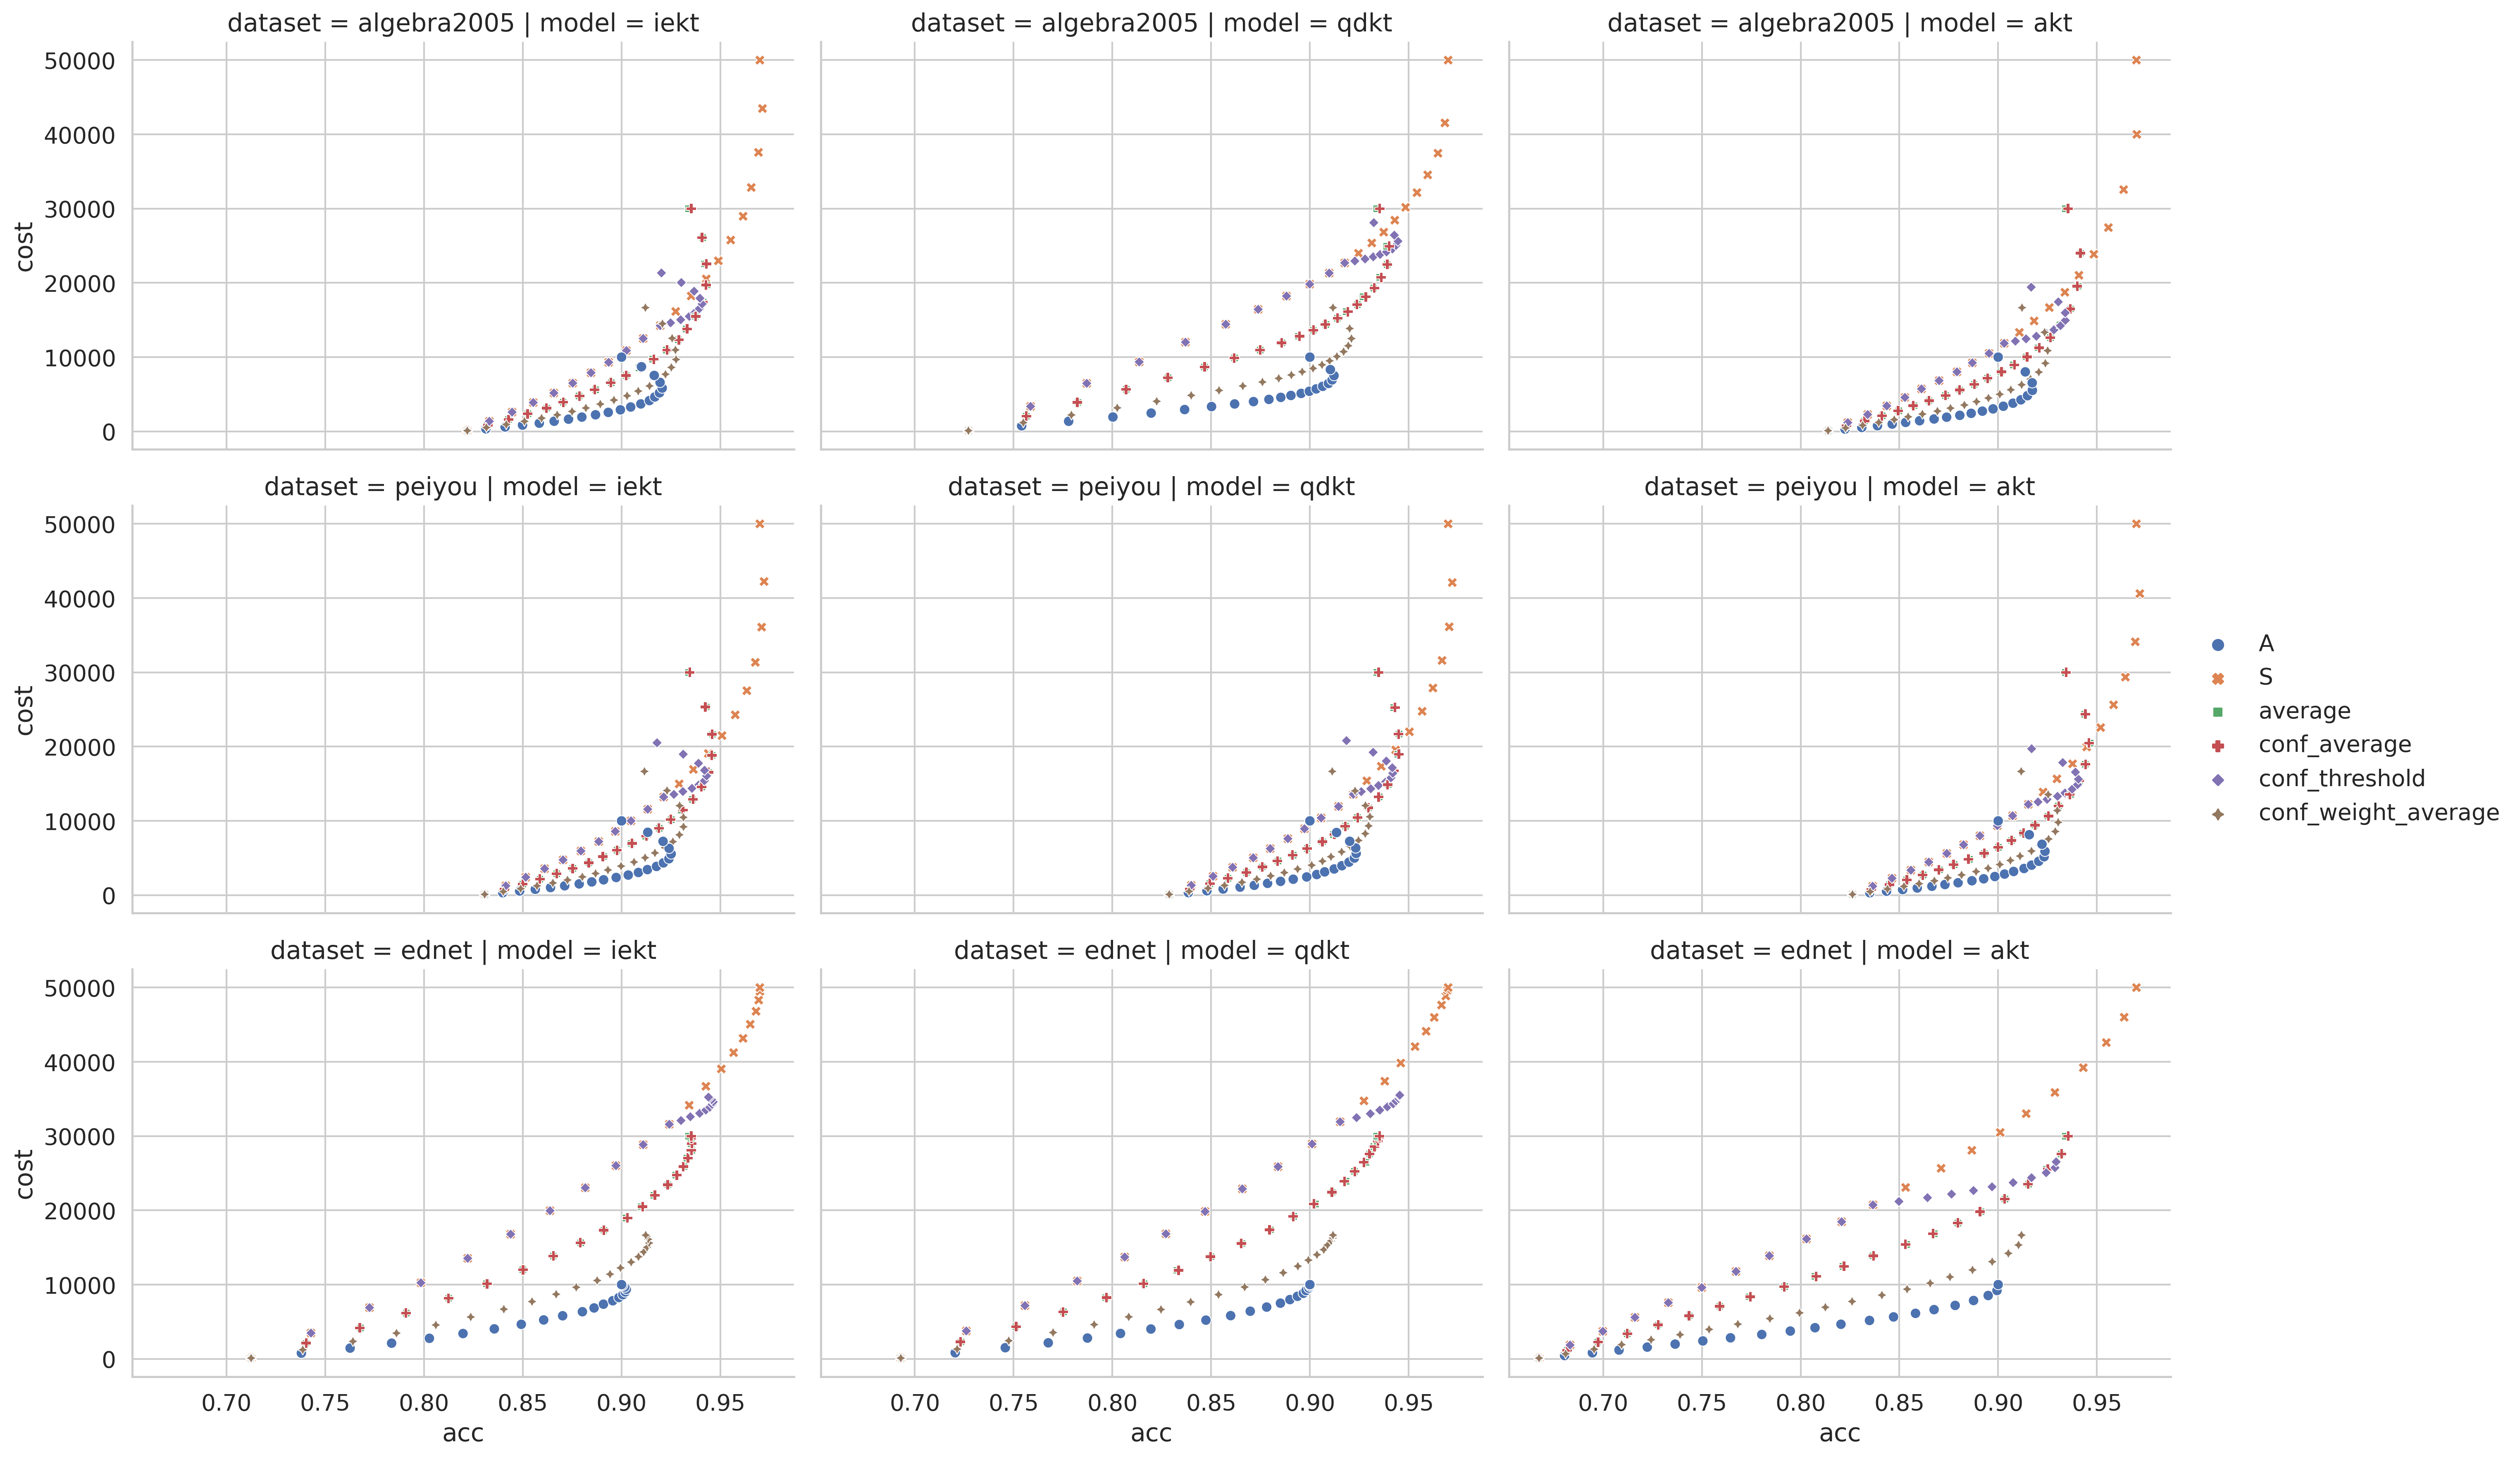

In [10]:
plt.rcParams['figure.dpi'] = 300  # 图形分辨率
sns.set_theme(context='notebook',style='whitegrid',font_scale=1.2)
#g = sns.scatterplot(data=df_temp, x="acc", y='cost', hue='alloc_mode',style="alloc_mode" )
g = sns.FacetGrid(df_mean,col="model",row='dataset', margin_titles=False,height=4,aspect=1.5,legend_out=True)
g.map_dataframe(sns.scatterplot, x="acc",y="cost",hue='alloc_mode', style="alloc_mode" ) #,hue='alloc_mode', )
g.add_legend()
#g.legend(bbox_to_anchor=(1, 1))
                    #markers=['+','D','*','P','^','o'])
#g.set_xticks(np.arange(0.7, 1.01, 0.05))
#g.set_yticks(np.arange(0, 50.1, 5))

### tau 和 auc/score的关系

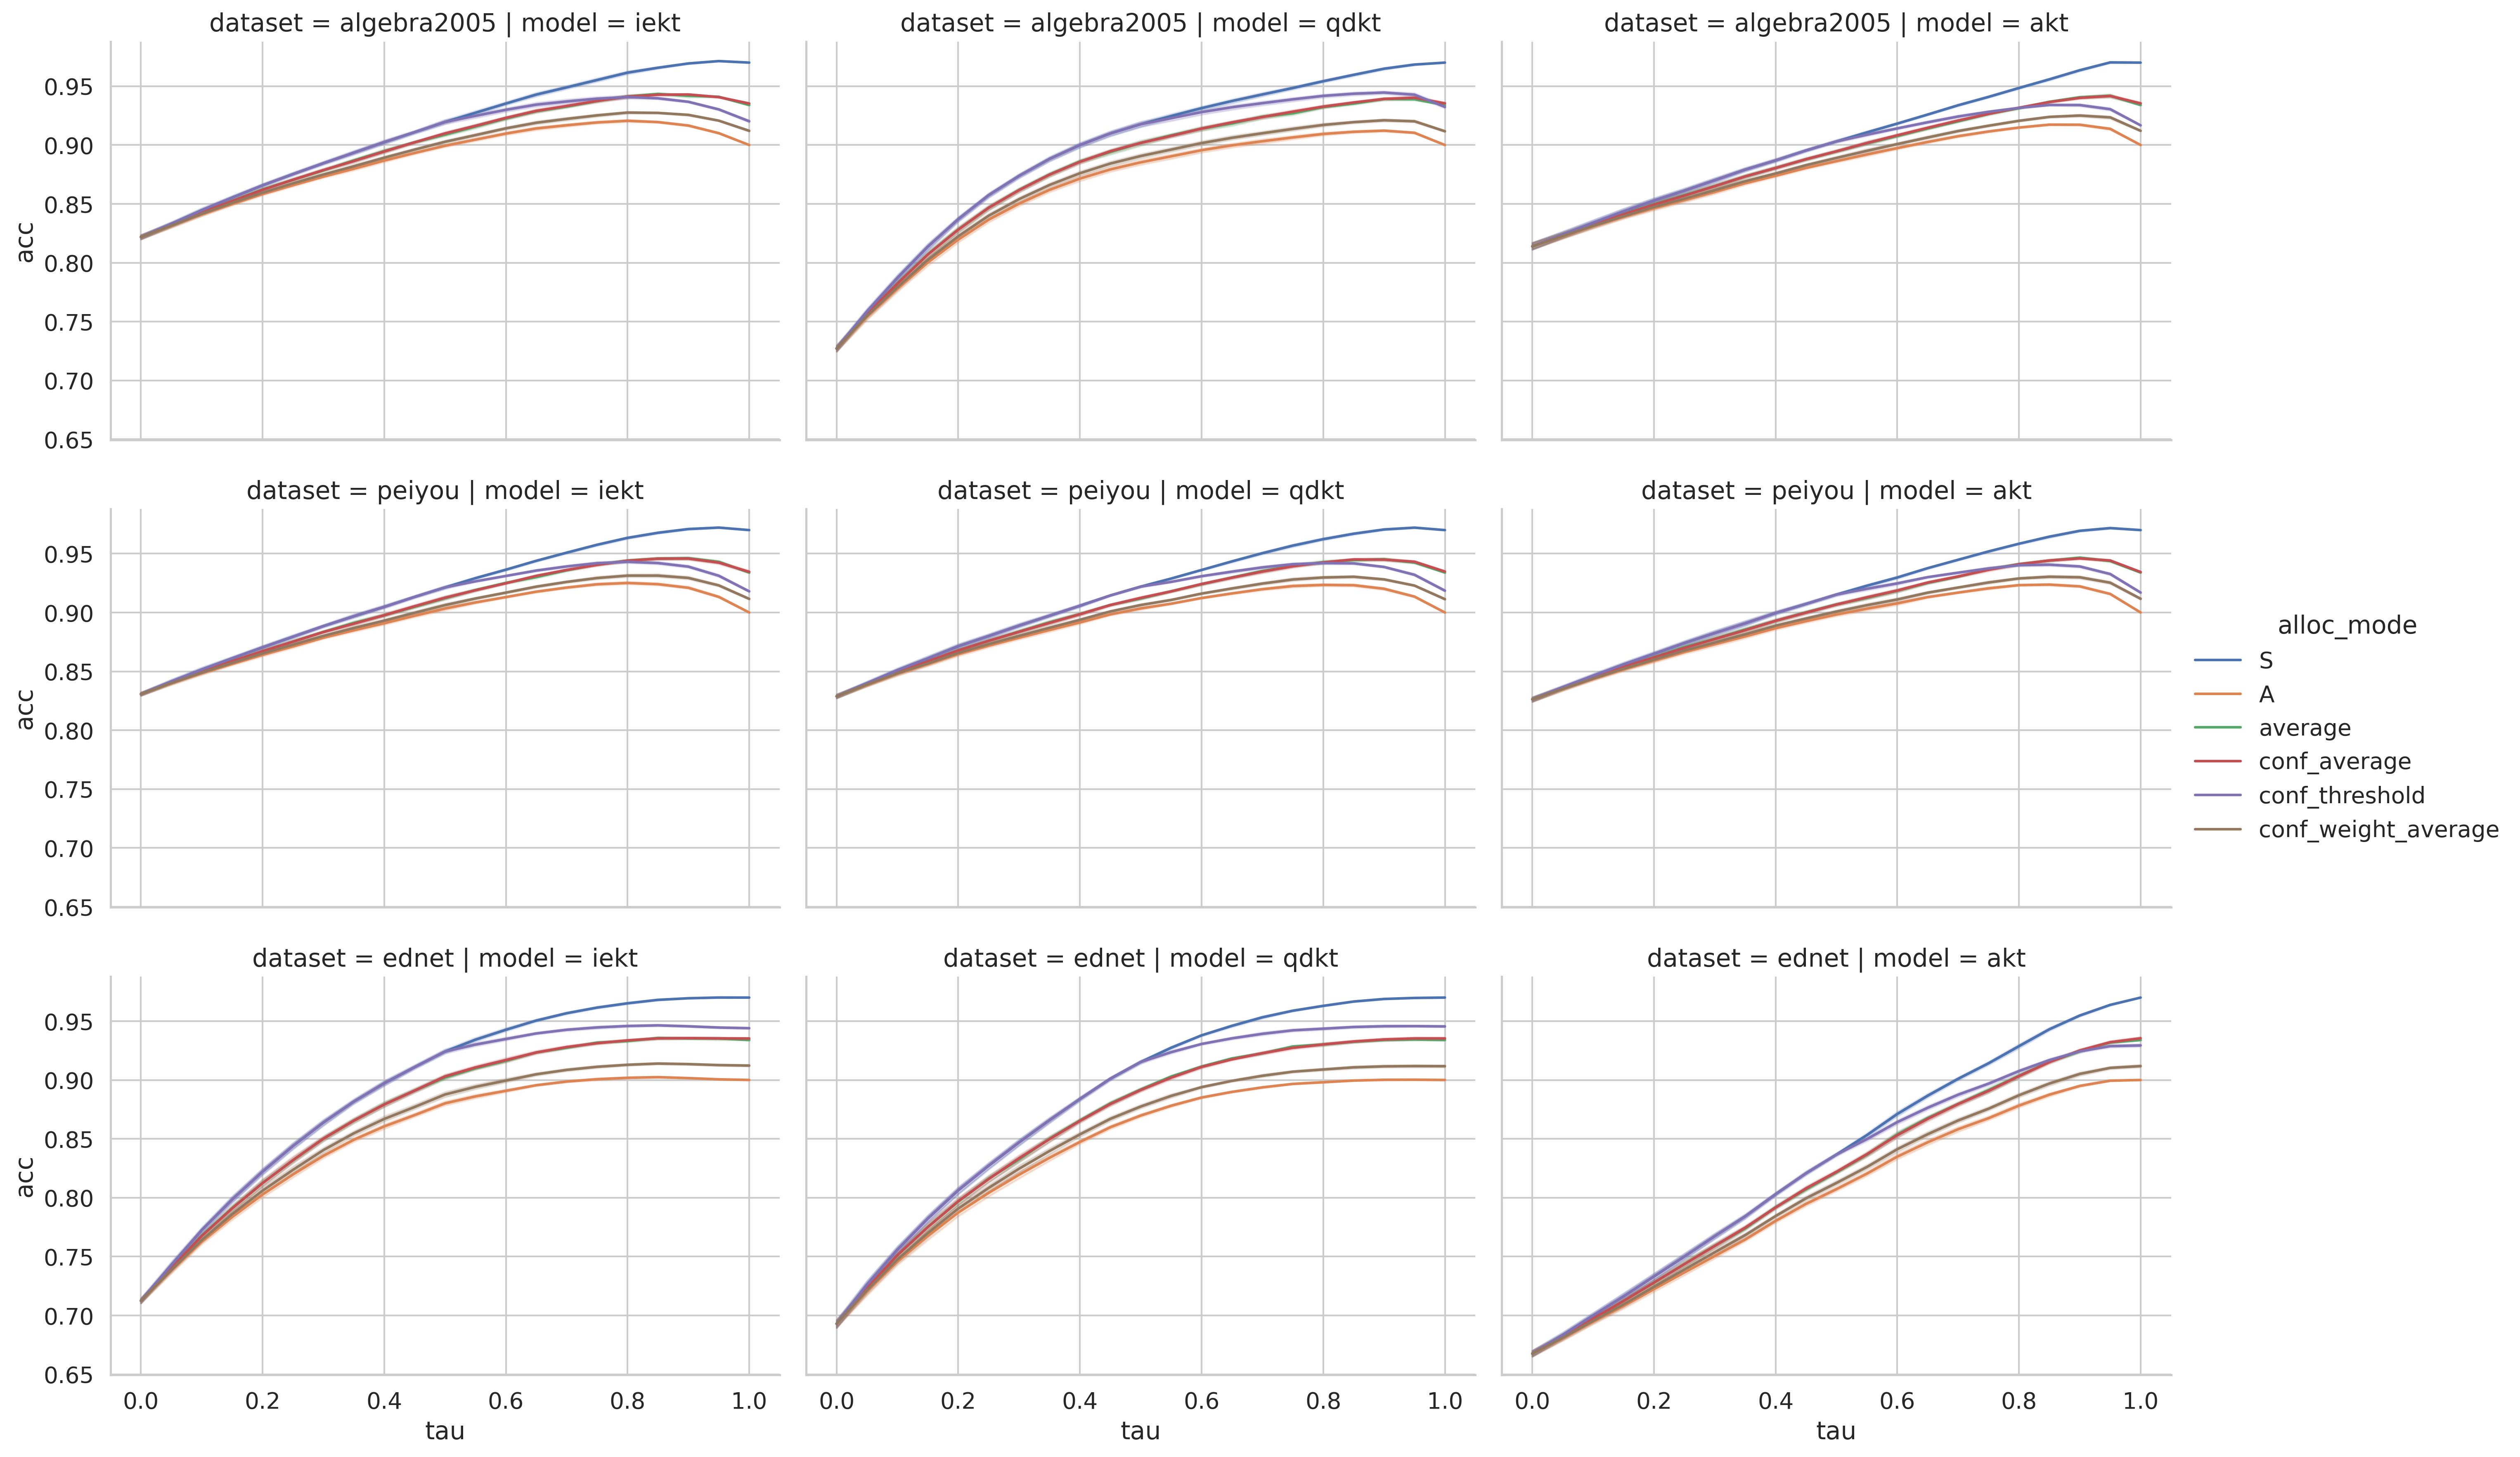

In [57]:
plt.rcParams['figure.dpi'] = 300  # 图形分辨率
sns.set_theme(context='notebook',style='whitegrid',font_scale=1.2)
g = sns.FacetGrid(df_report,col="model",row='dataset', margin_titles=False,hue='alloc_mode',height=4,aspect=1.5,legend_out=True)
g.map(sns.lineplot, "tau","acc")
g.add_legend()
#plt.savefig("data/imgs/tau-auc.pdf",bbox_inches="tight")

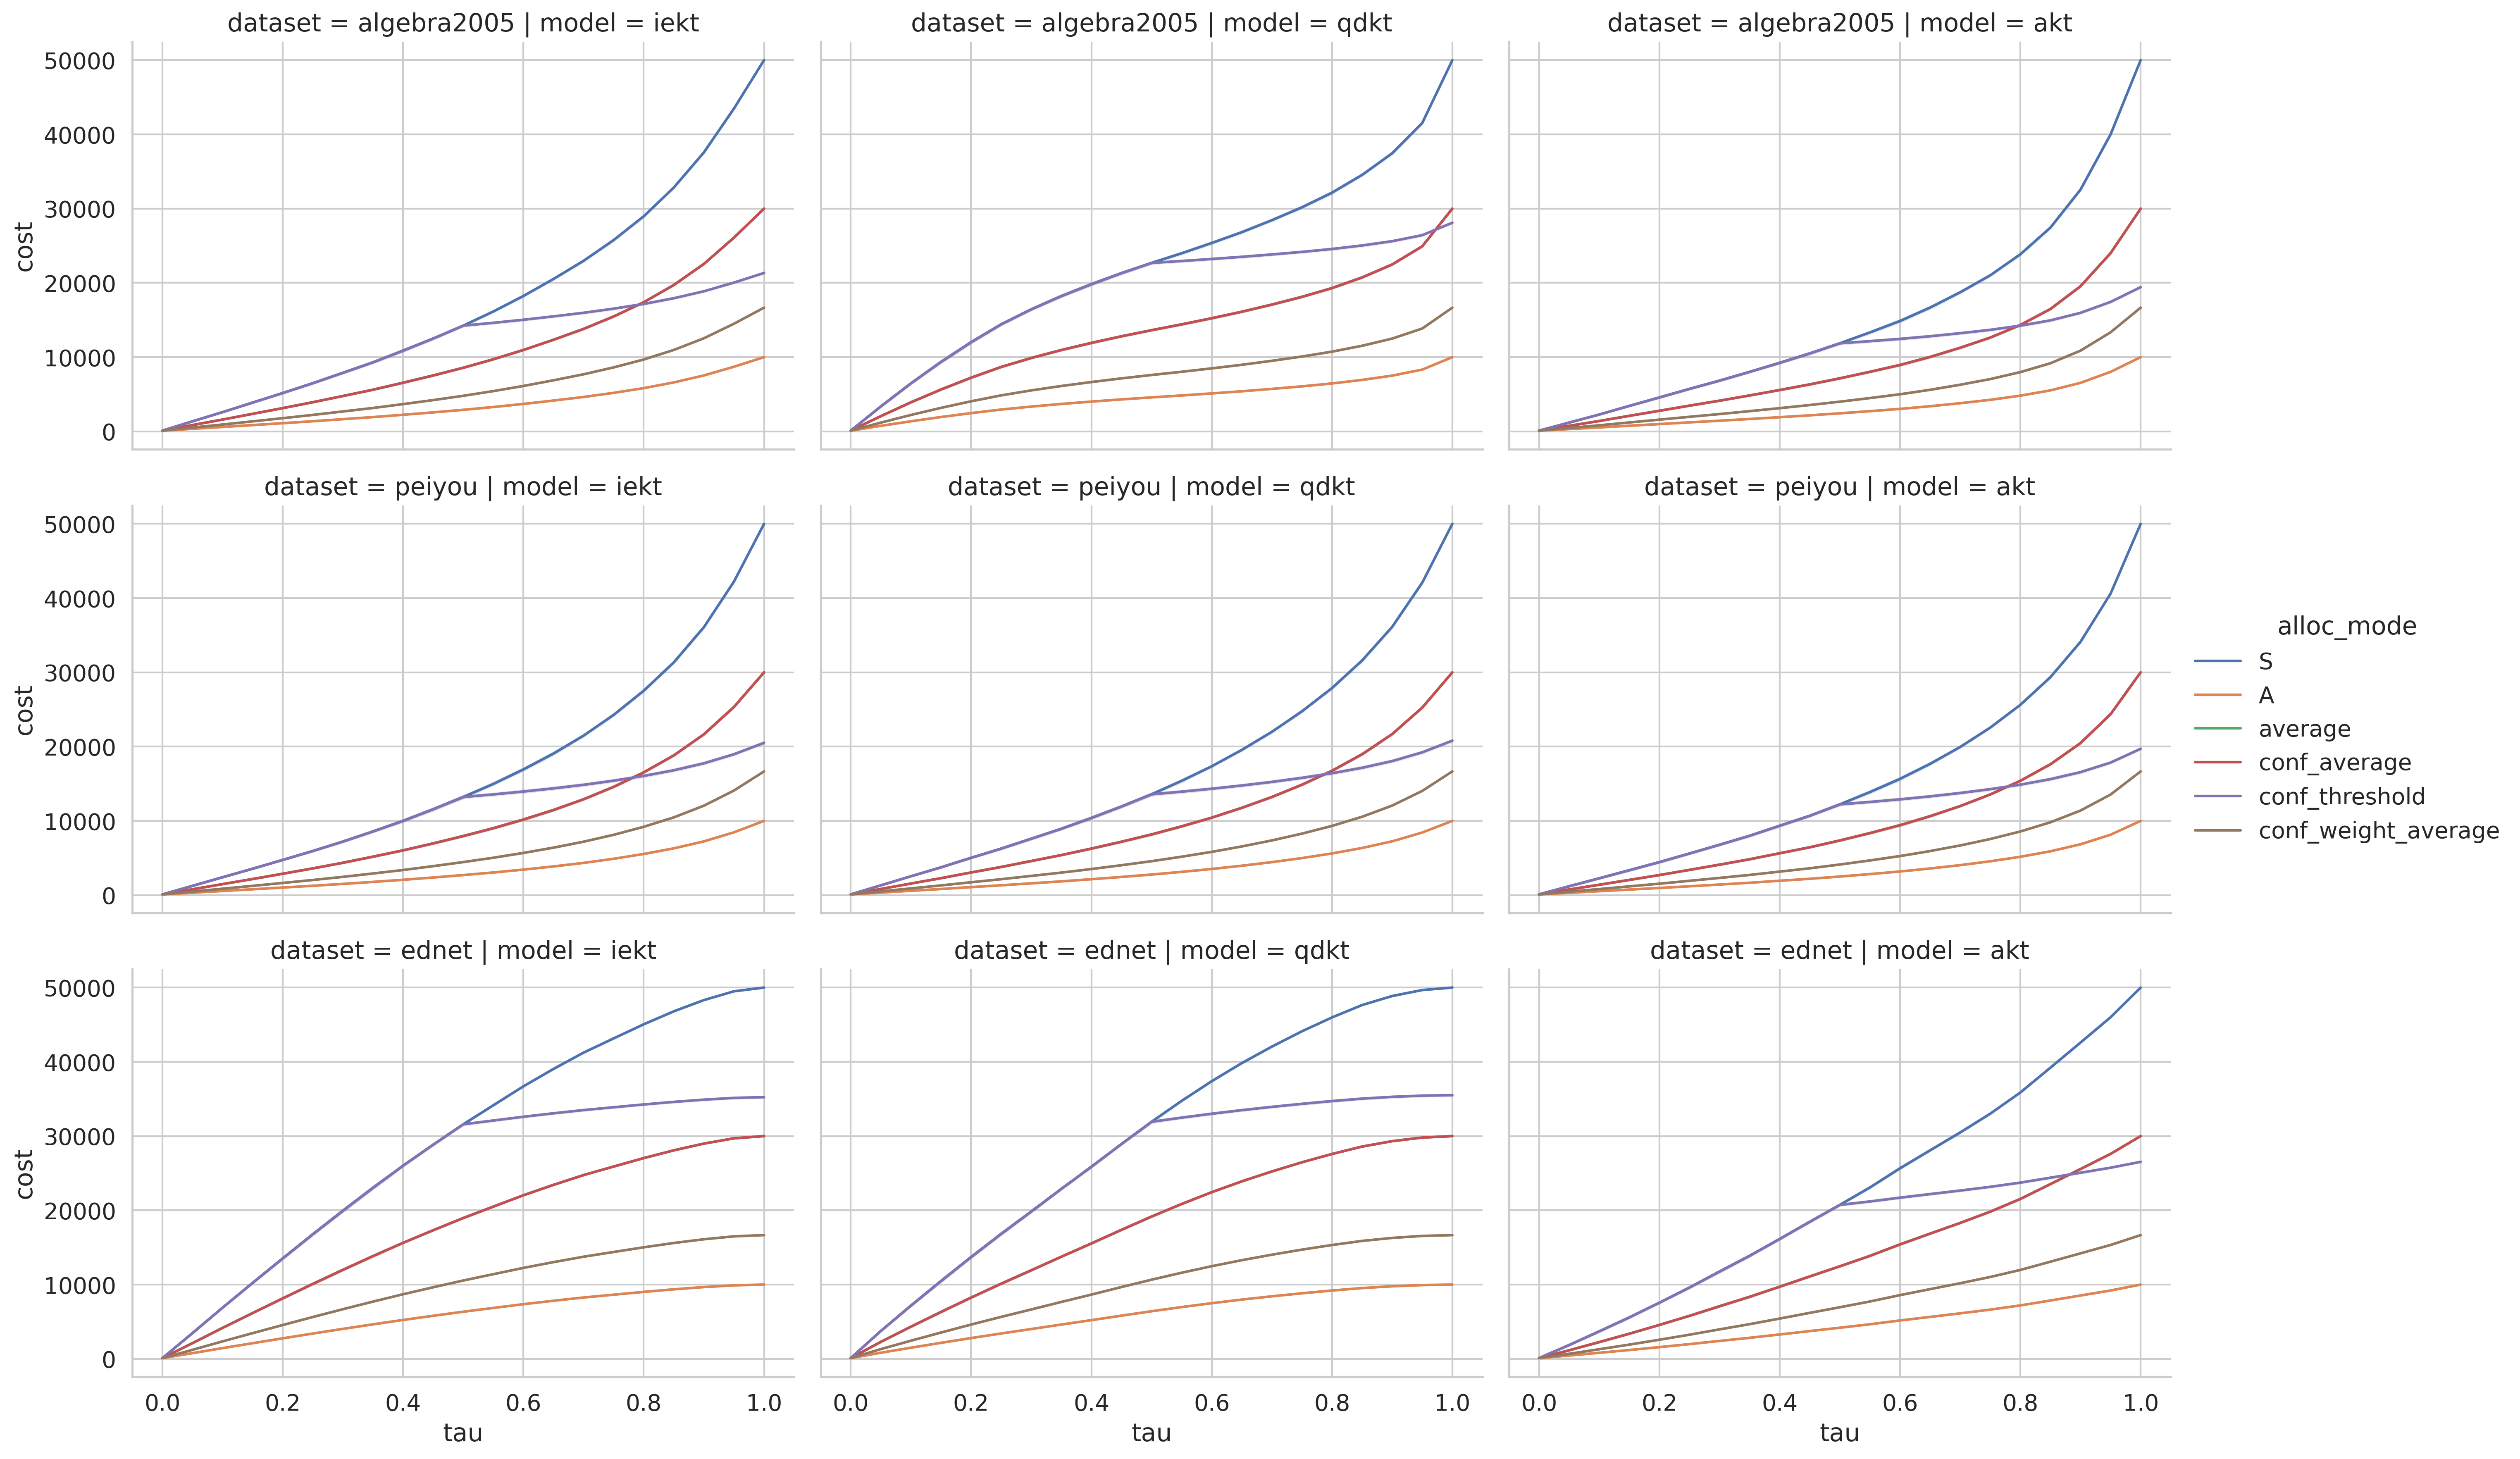

In [58]:
plt.rcParams['figure.dpi'] = 300  # 图形分辨率
sns.set_theme(context='notebook',style='whitegrid',font_scale=1.2)
# fig,ax = plt.figure(figsize=(10,5))
g = sns.FacetGrid(df_report,col="model",row='dataset', margin_titles=False,hue='alloc_mode',height=4,aspect=1.5,legend_out=True)
g.map(sns.lineplot, "tau","cost")
g.add_legend()
#plt.savefig("data/imgs/tau-cost.pdf",bbox_inches="tight")

In [59]:
# df_report.sort_values("cost",ascending=False).drop_duplicates(["model","alloc_mode"])

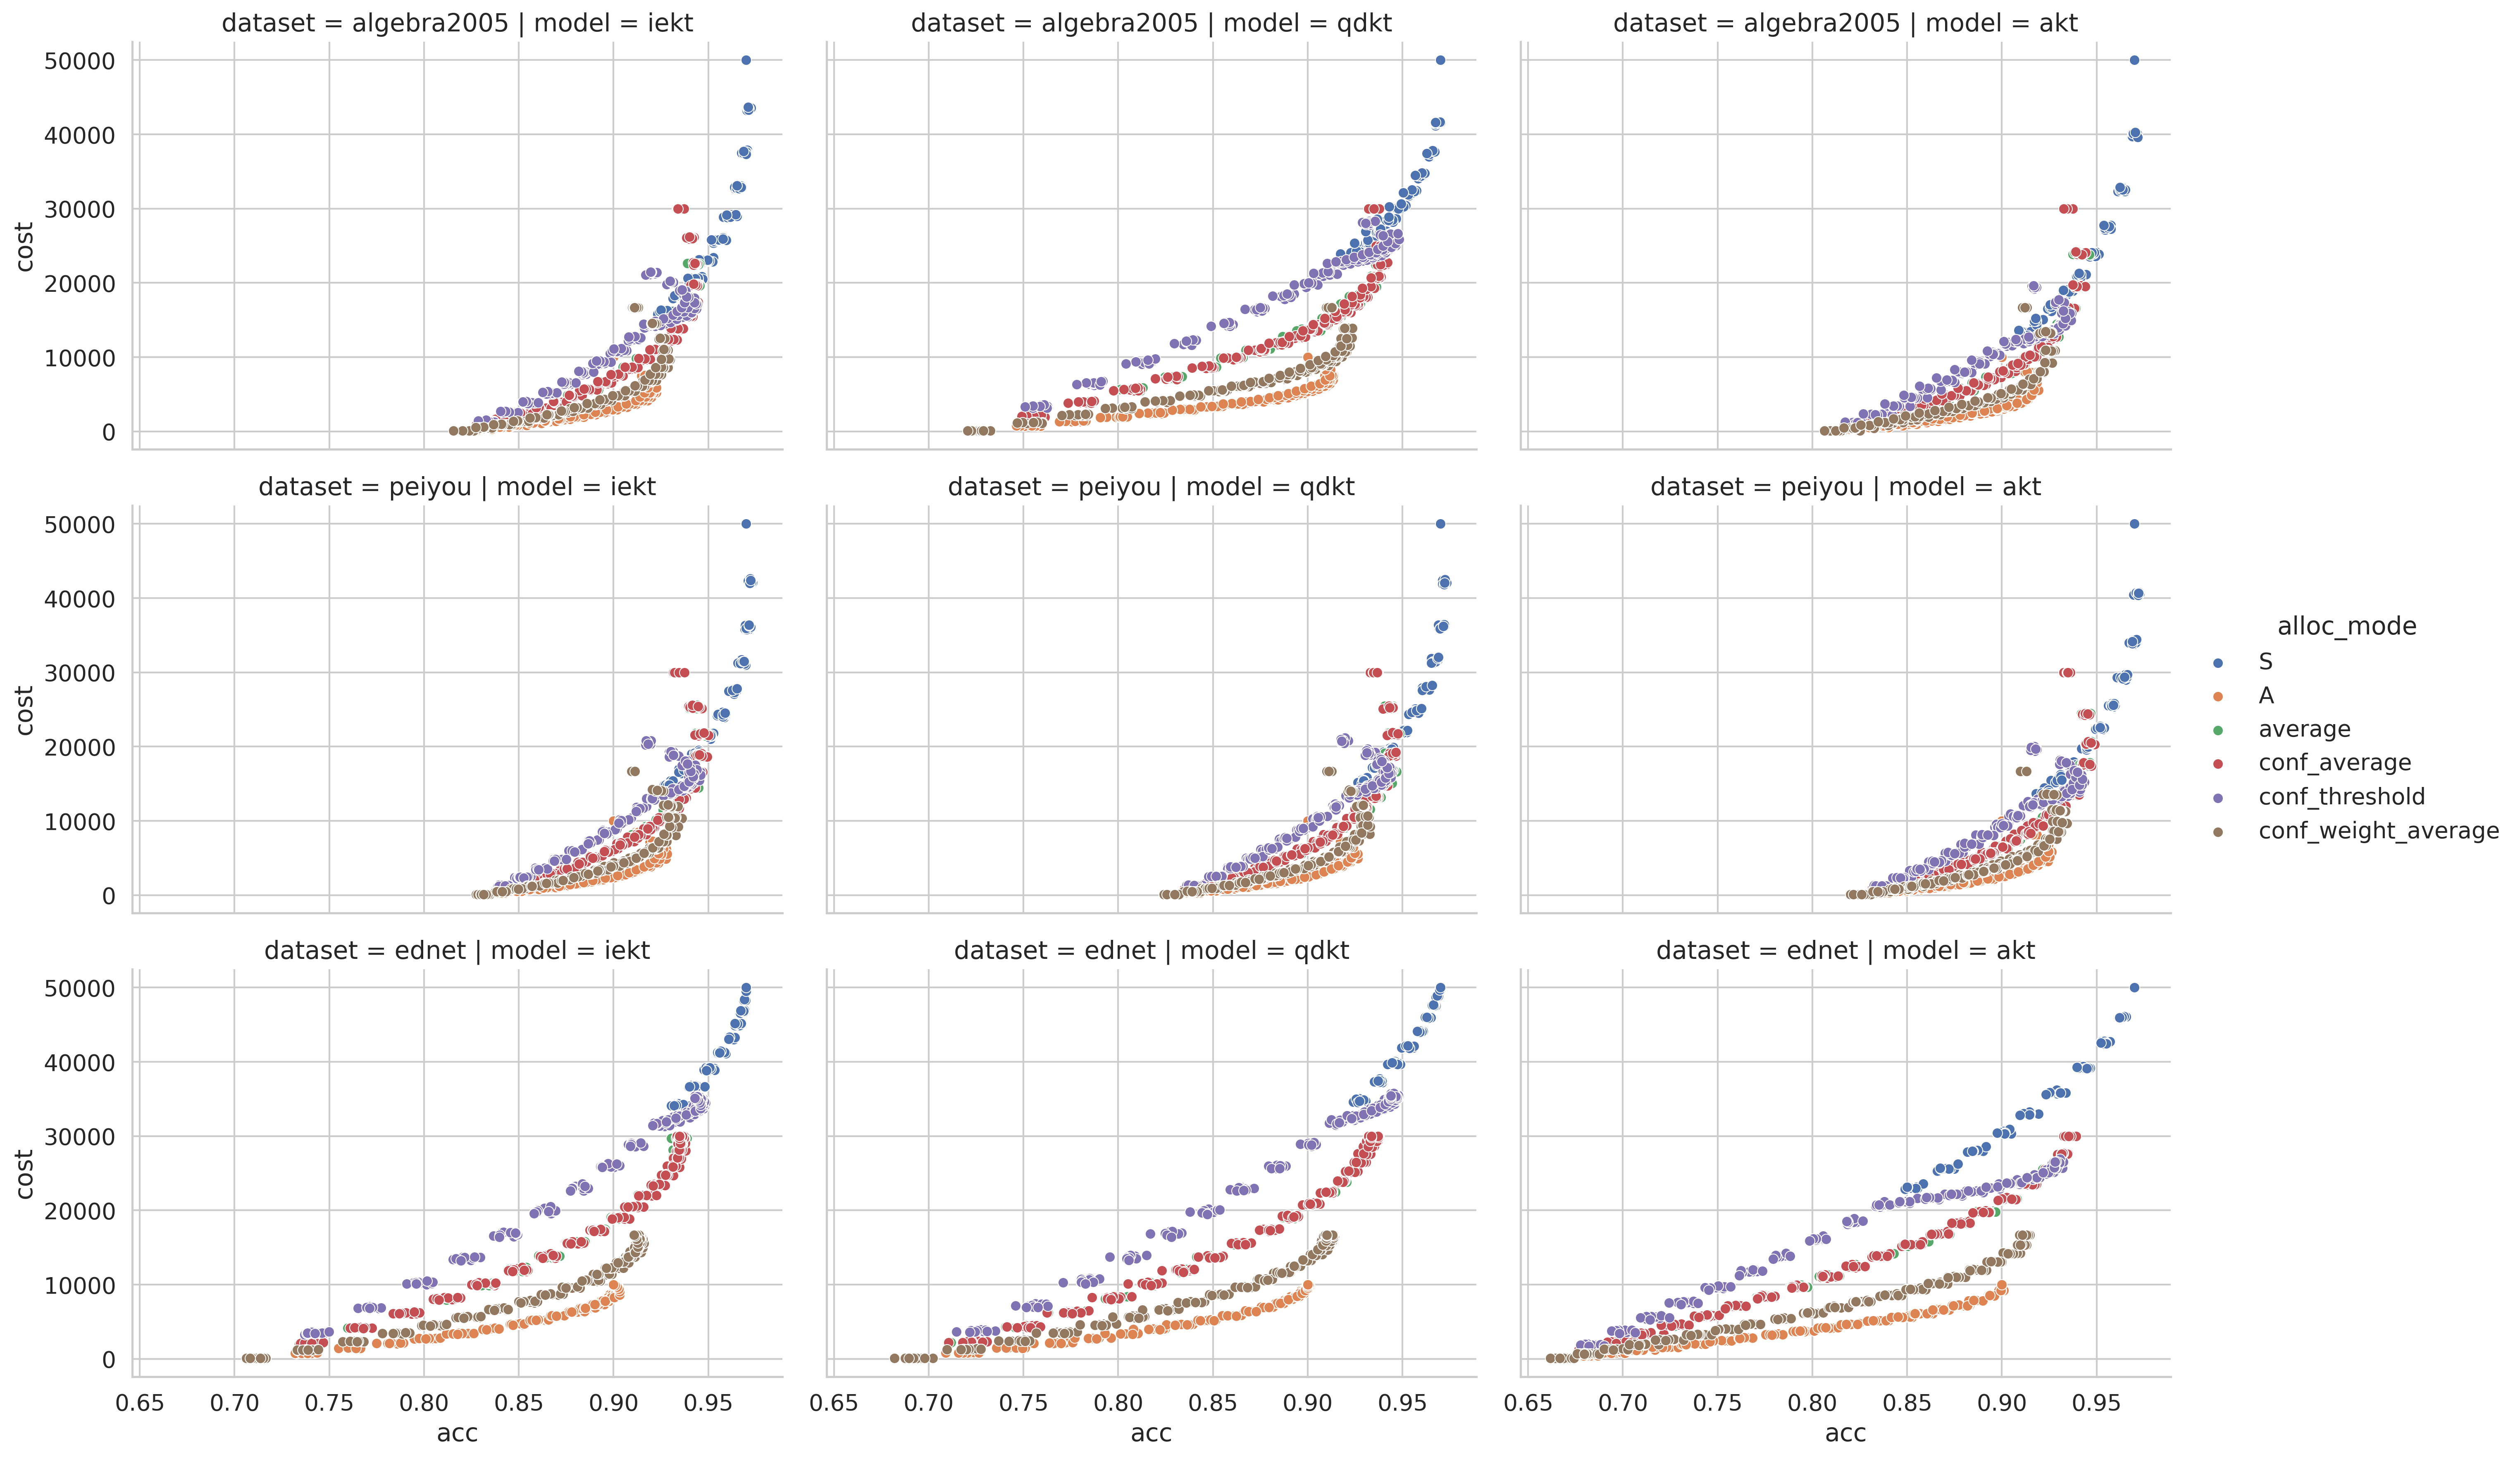

In [60]:
plt.rcParams['figure.dpi'] = 300  # 图形分辨率
sns.set_theme(context='notebook',style='whitegrid',font_scale=1.2)
# fig,ax = plt.figure(figsize=(10,5))
g = sns.FacetGrid(df_report,col="model",row='dataset', margin_titles=False,hue='alloc_mode',height=4,aspect=1.5,legend_out=True)
g.map(sns.scatterplot, "acc","cost")
g.add_legend()

In [ ]:
# # fig,ax = plt.figure(figsize=(10,5))
# g = sns.FacetGrid(df_report,col="model",row='dataset', margin_titles=False,hue='alloc_mode',height=4,aspect=1.5,legend_out=True)
# g.map(sns.lineplot, "tau","auto_score_cover")
# g.add_legend()
# plt.savefig("data/imgs/tau-auto_score_cover.pdf",bbox_inches="tight")

### acc VS cost

In [11]:
sns.set_theme(context='notebook',style='whitegrid',font_scale=1.1)
sns.set_style("whitegrid", {"grid.linestyle": "--"})

In [12]:
alloc_mode_plot_dict = {}
for alloc_mode in ['S','A']:
    plot_list = []
    for dataset in dataset_list:
        data = df_report[(df_report['alloc_mode']==alloc_mode)&(df_report['dataset']==dataset)].copy()
        row_list = []
        for (tau,model),group in data.groupby(["tau","model"]):
            
            row = {"dataset":dataset,"tau":tau,"Model":col_map[model],"alloc_mode":alloc_mode}
            row.update(group.mean(numeric_only=True).to_dict())
            row_list.append(row)
        df_plot = pd.DataFrame(row_list)
        df_plot['cost_k'] = df_plot['cost']/1000
        plot_list.append(df_plot)
    alloc_mode_plot_dict[alloc_mode] = plot_list

In [13]:
sub_dataset_list = dataset_list
len(sub_dataset_list)

3

#### 所有数据集

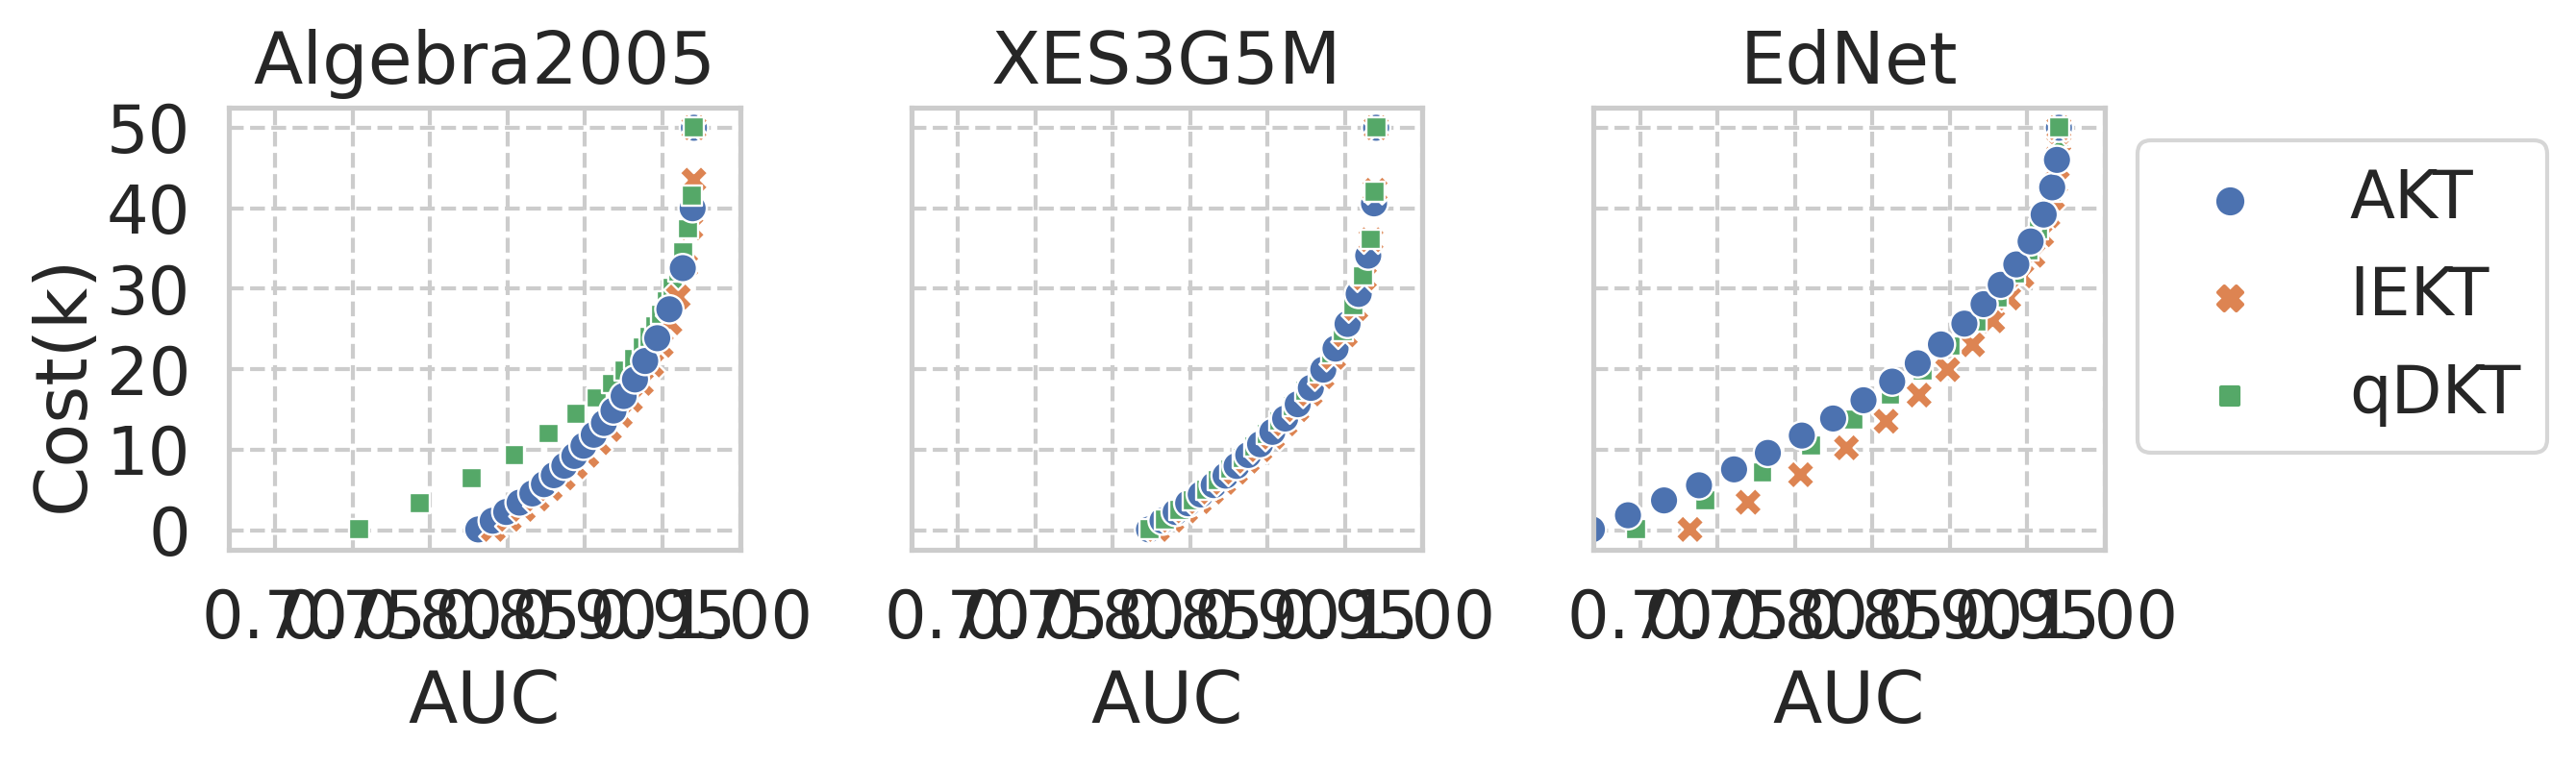

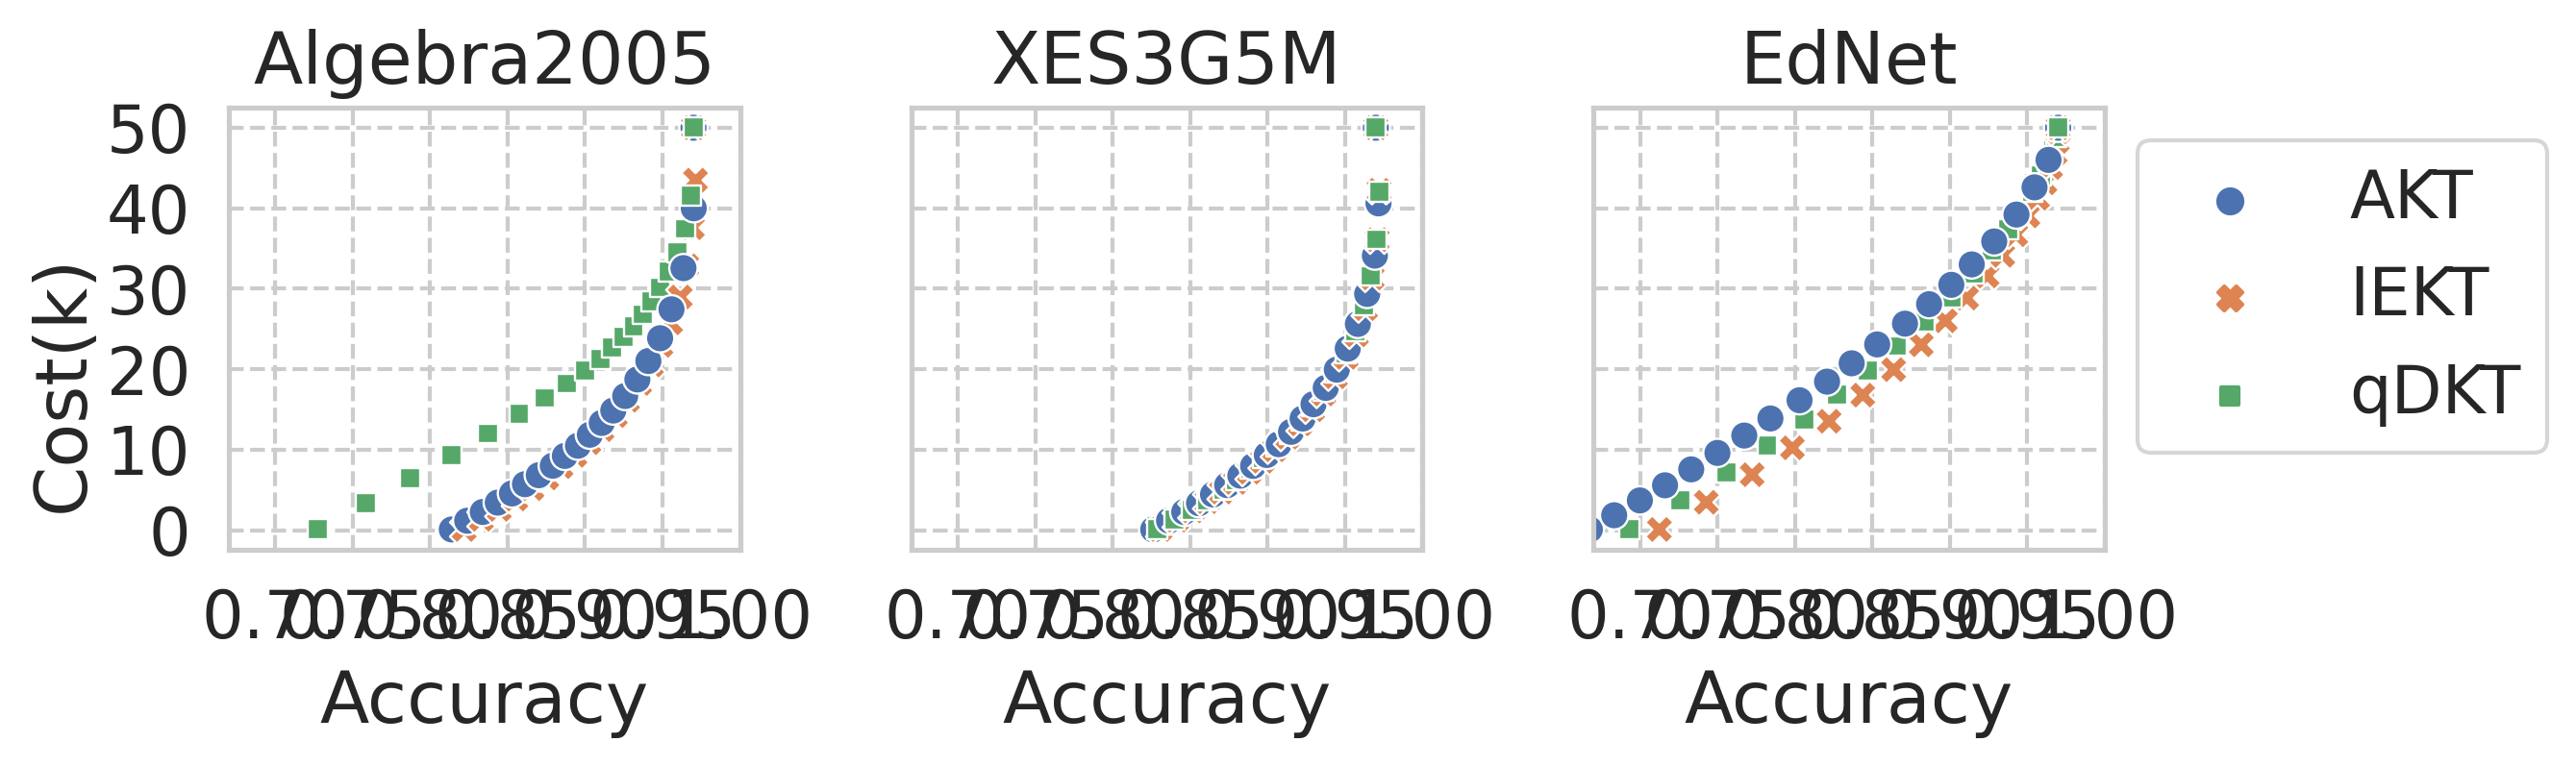

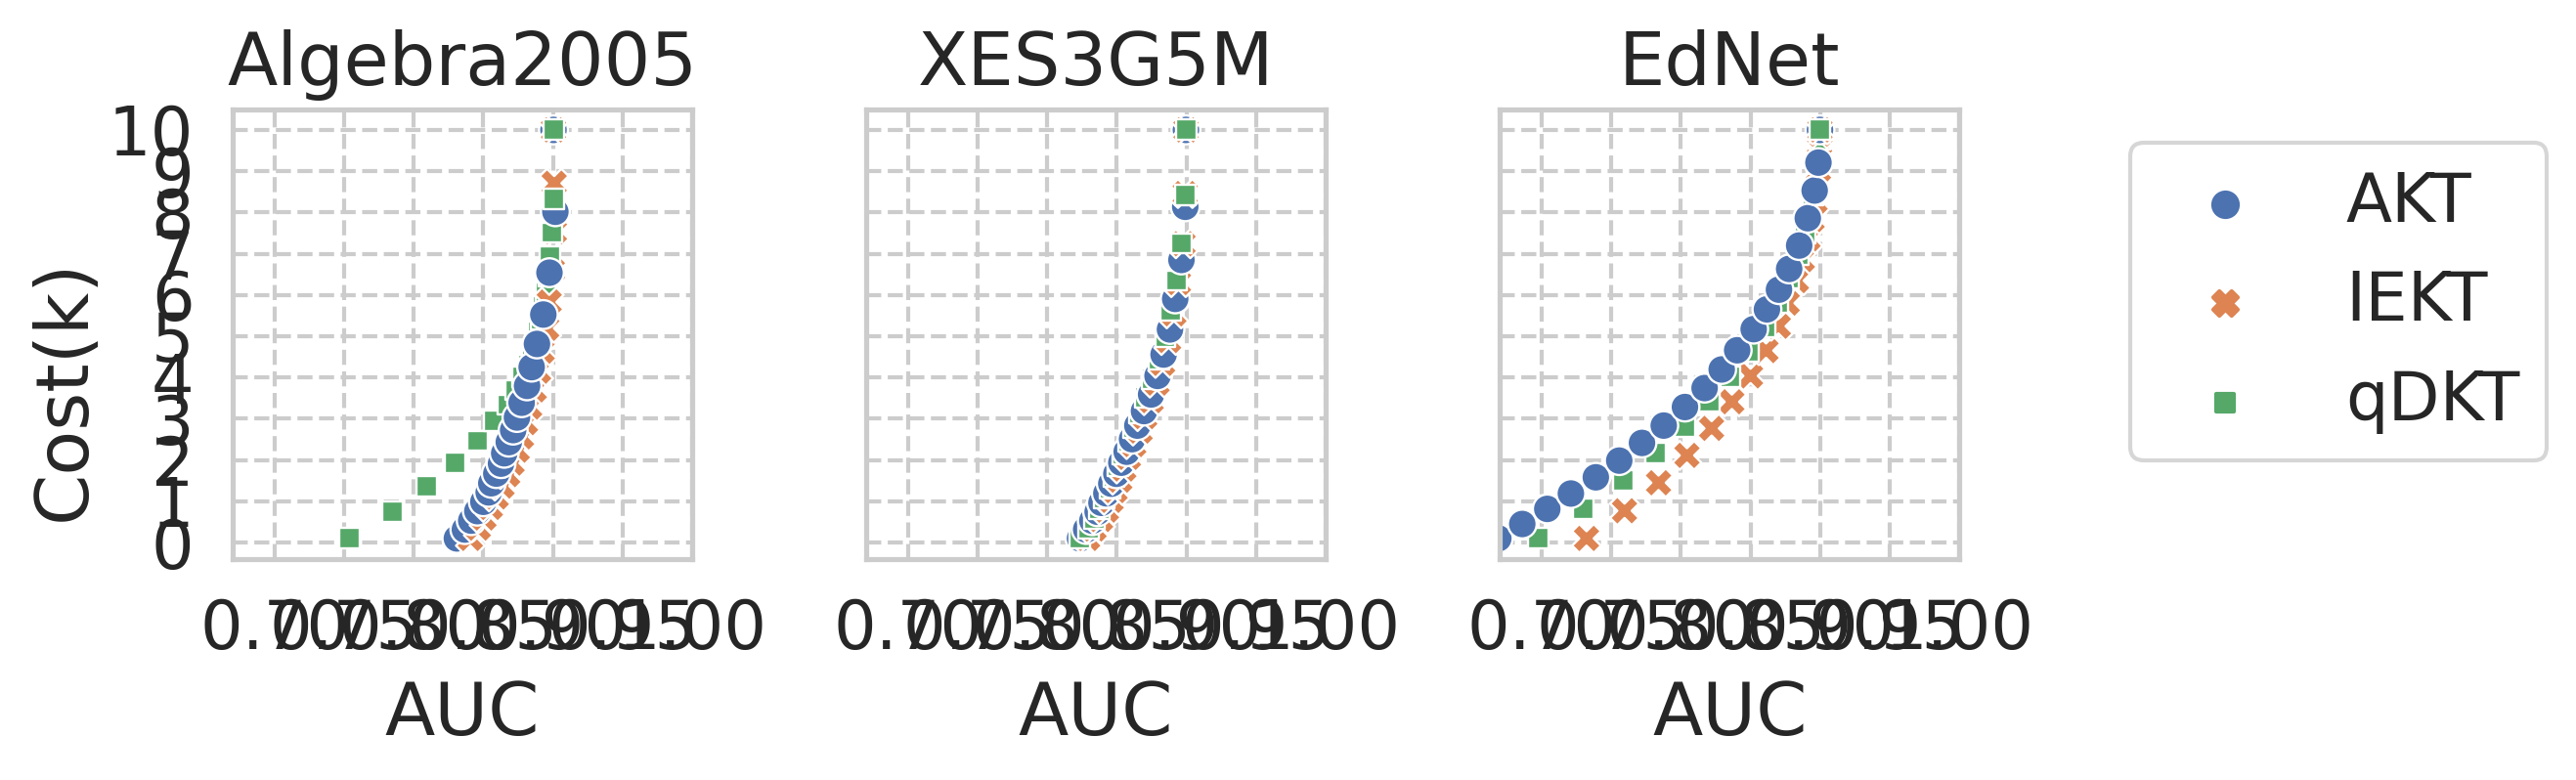

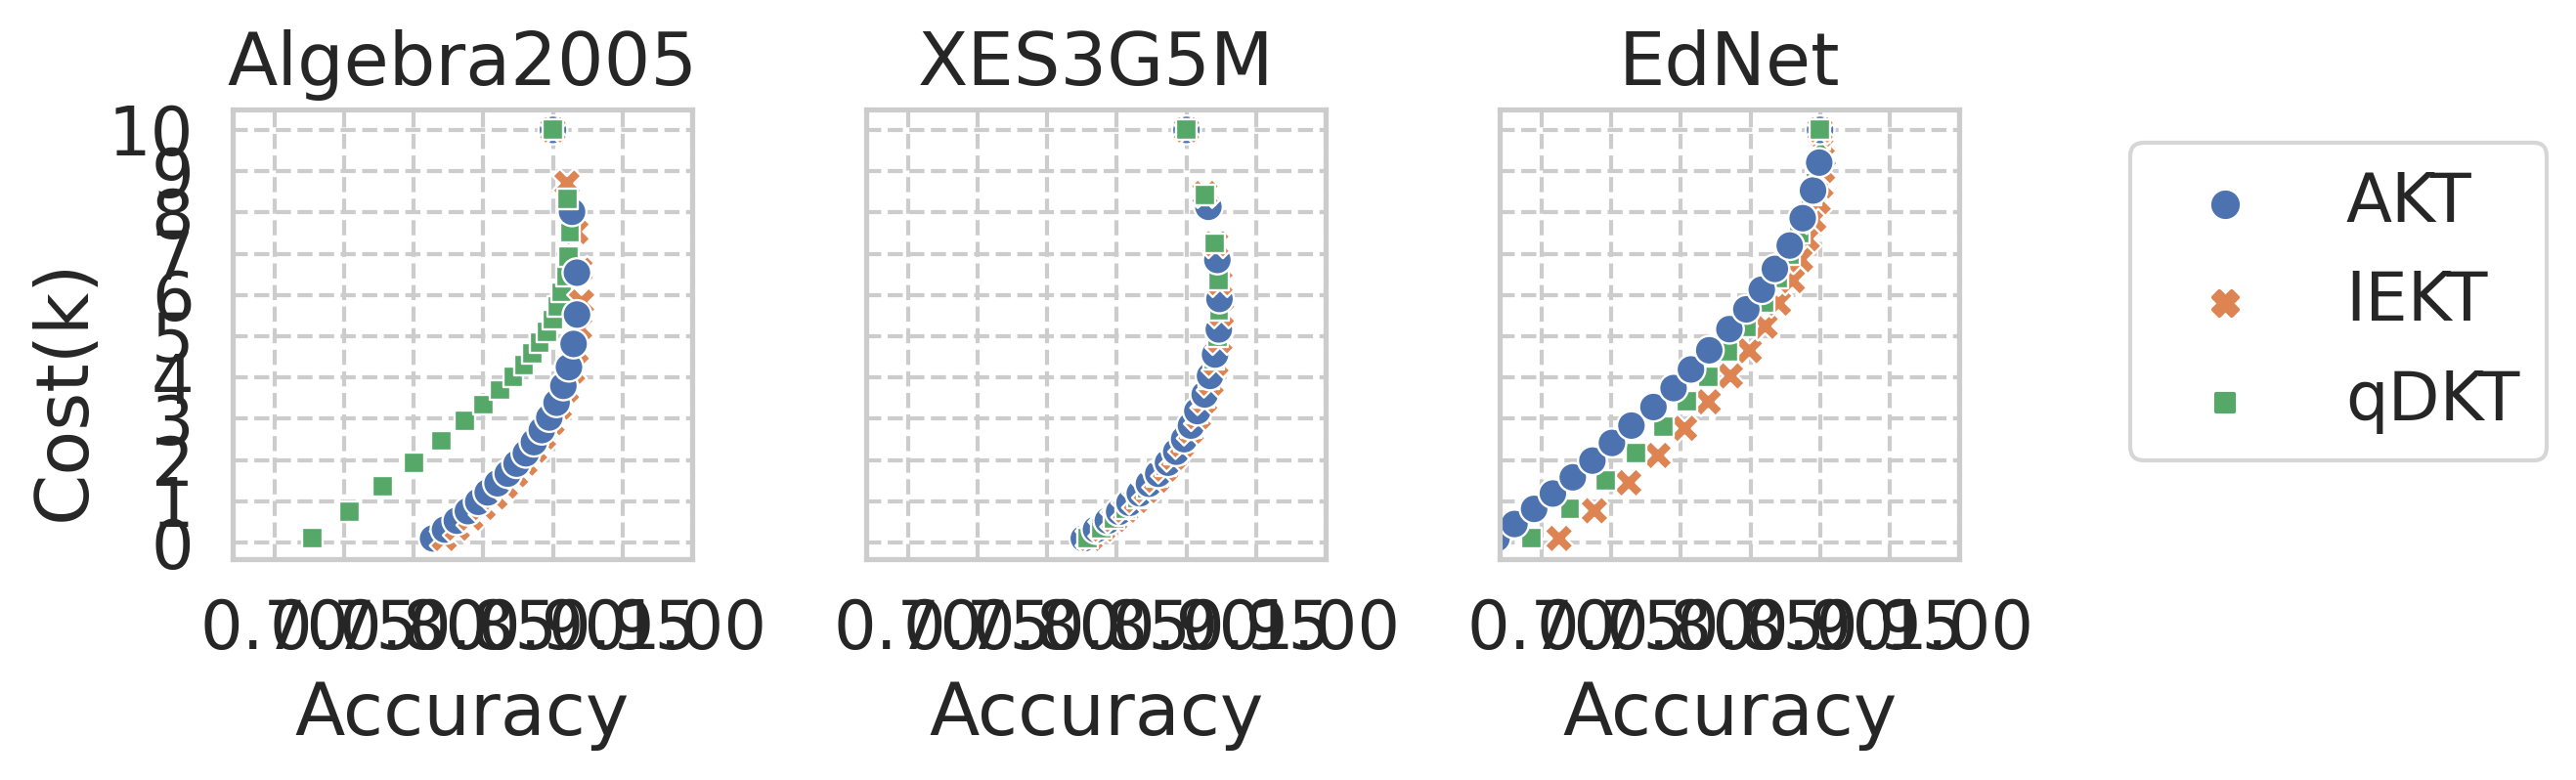

In [19]:
for alloc_mode in ['S', 'A']:
    for metric in ['auc', 'acc']:
        fig, ax = plt.subplots(1, len(sub_dataset_list), figsize=( len(sub_dataset_list)*3, 3), sharey=True, sharex=True )
        i = 0
        for i in range(len(sub_dataset_list)):
            dataset_index = dataset_list.index(sub_dataset_list[i])
            df_plot = alloc_mode_plot_dict[alloc_mode][dataset_index]
            df_plot[df_plot['dataset'].isin(sub_dataset_list)]
            sns.scatterplot(data=df_plot, x=metric,
                            y='cost_k', hue='Model', style='Model', s=50, ax=ax[i], legend=i == len(sub_dataset_list)-1)
            ax[i].set_title(col_map[sub_dataset_list[i]])
#             ax[i].axvline(x=0.85, color='r', linestyle='-.')
            ax[i].set_xticks(np.arange(0.7, 1.01, 0.05))
            if alloc_mode == "S":
                ax[i].set_yticks(np.arange(0, 50.1, 10))
            elif alloc_mode == "A":
                ax[i].set_yticks(np.arange(0, 10.1, 1))
            ax[i].set_ylabel("")
            if metric == 'acc':
                ax[i].set_xlabel("Accuracy")
            else:
                ax[i].set_xlabel("AUC")
        plt.xlim(0.67, 1)
        plt.xlim(right=1)
        if alloc_mode == "S":
            plt.legend(bbox_to_anchor=(1, 1))
        elif alloc_mode == "A":
            plt.legend(bbox_to_anchor=(1.3, 1))
        plt.tight_layout()
    #     fig.text(0.5, 0, 'Accuracy', ha='center')
        fig.text(0, 0.5, 'Cost(k)', va='center', rotation='vertical')

        # plt.savefig(f"data/imgs/{alloc_mode}-{metric}-cost_all_dataset.pdf", bbox_inches="tight")
#         print(f"{alloc_mode}-{metric}")
    #     break

#### 部分数据集

In [68]:
sub_dataset_list = dataset_list

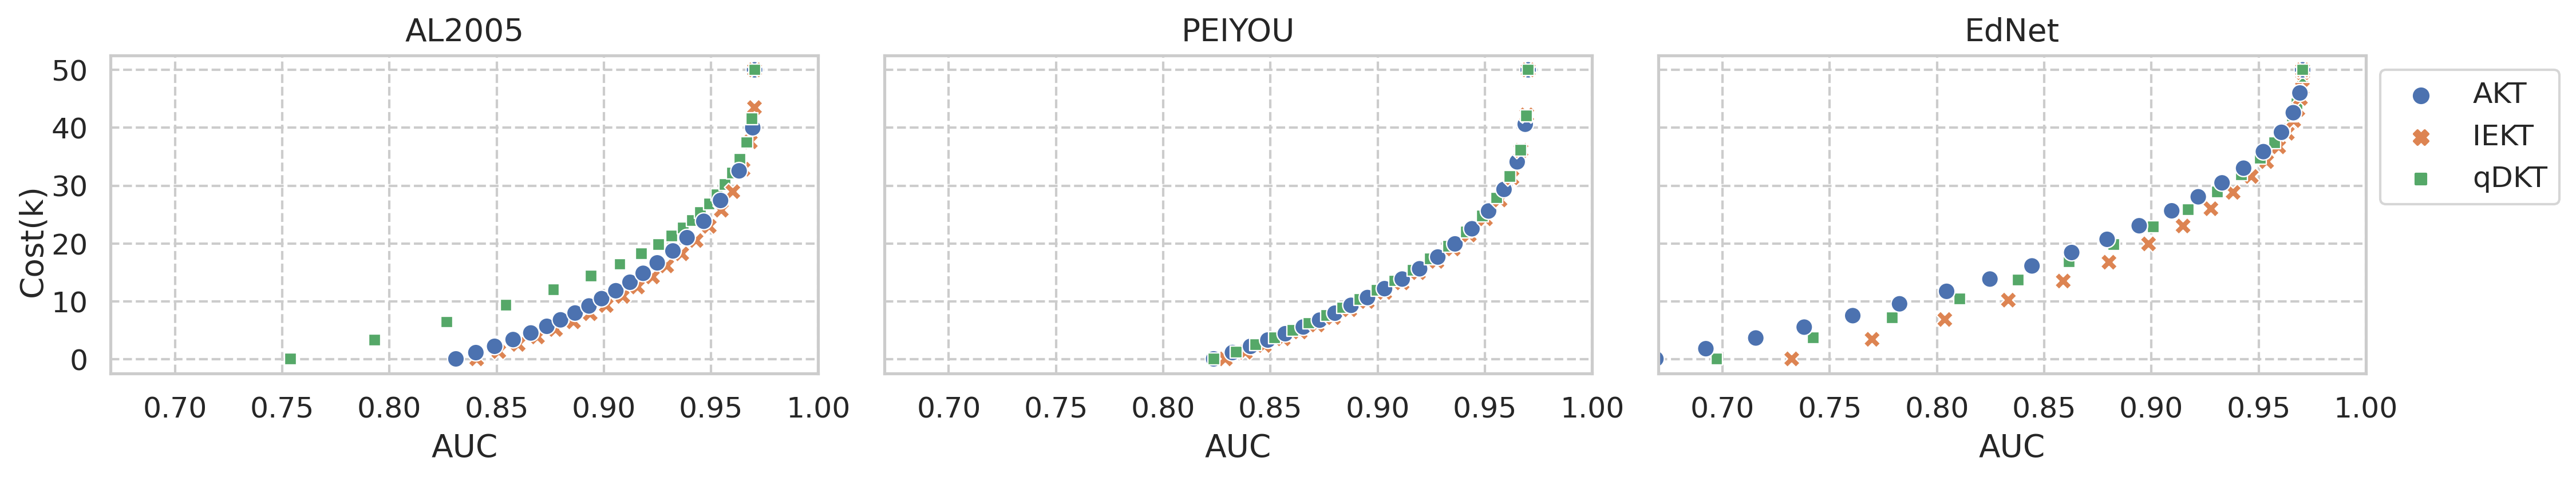

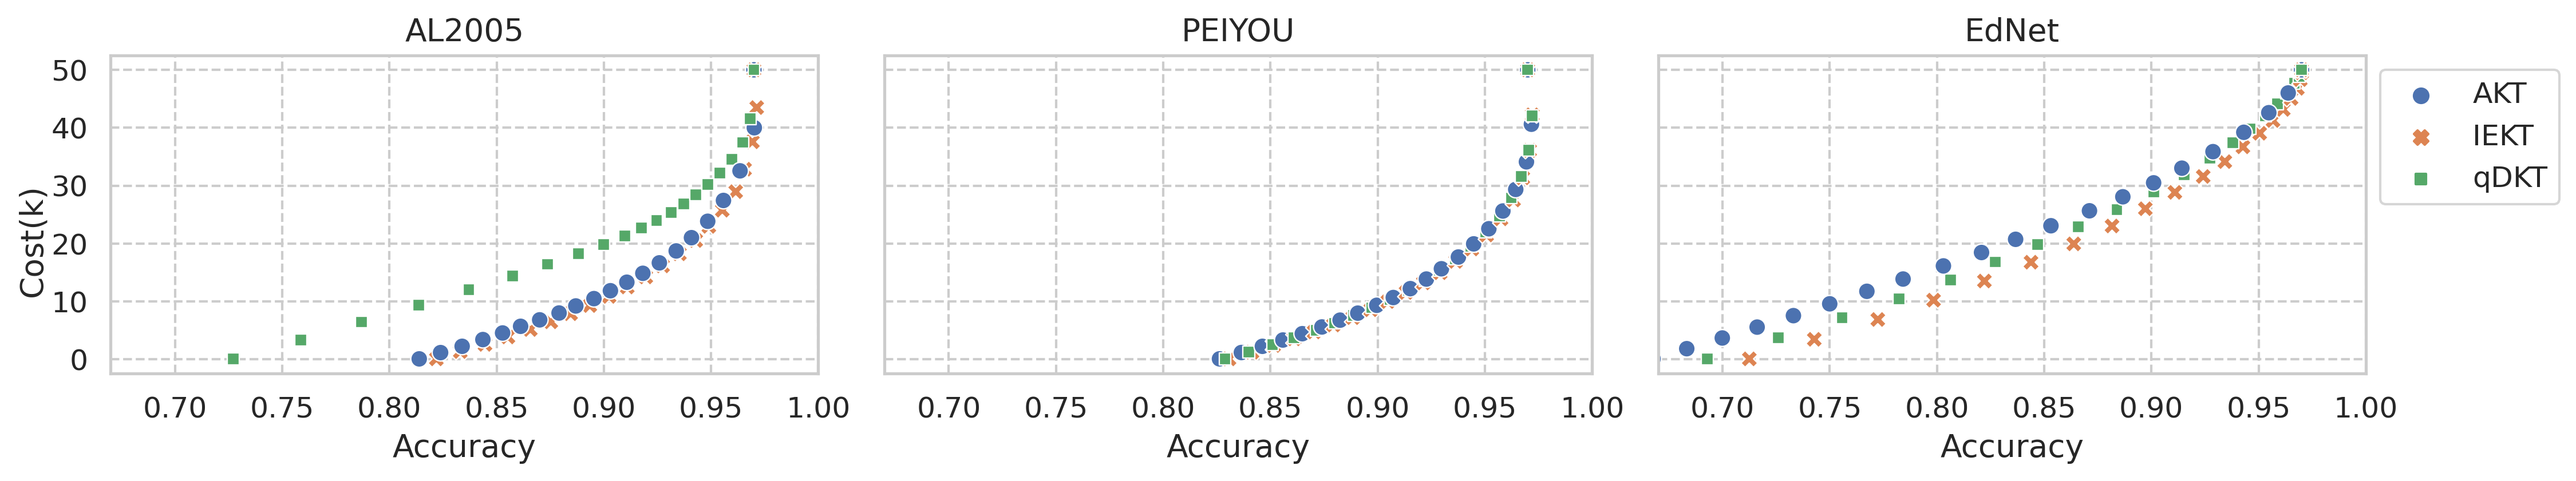

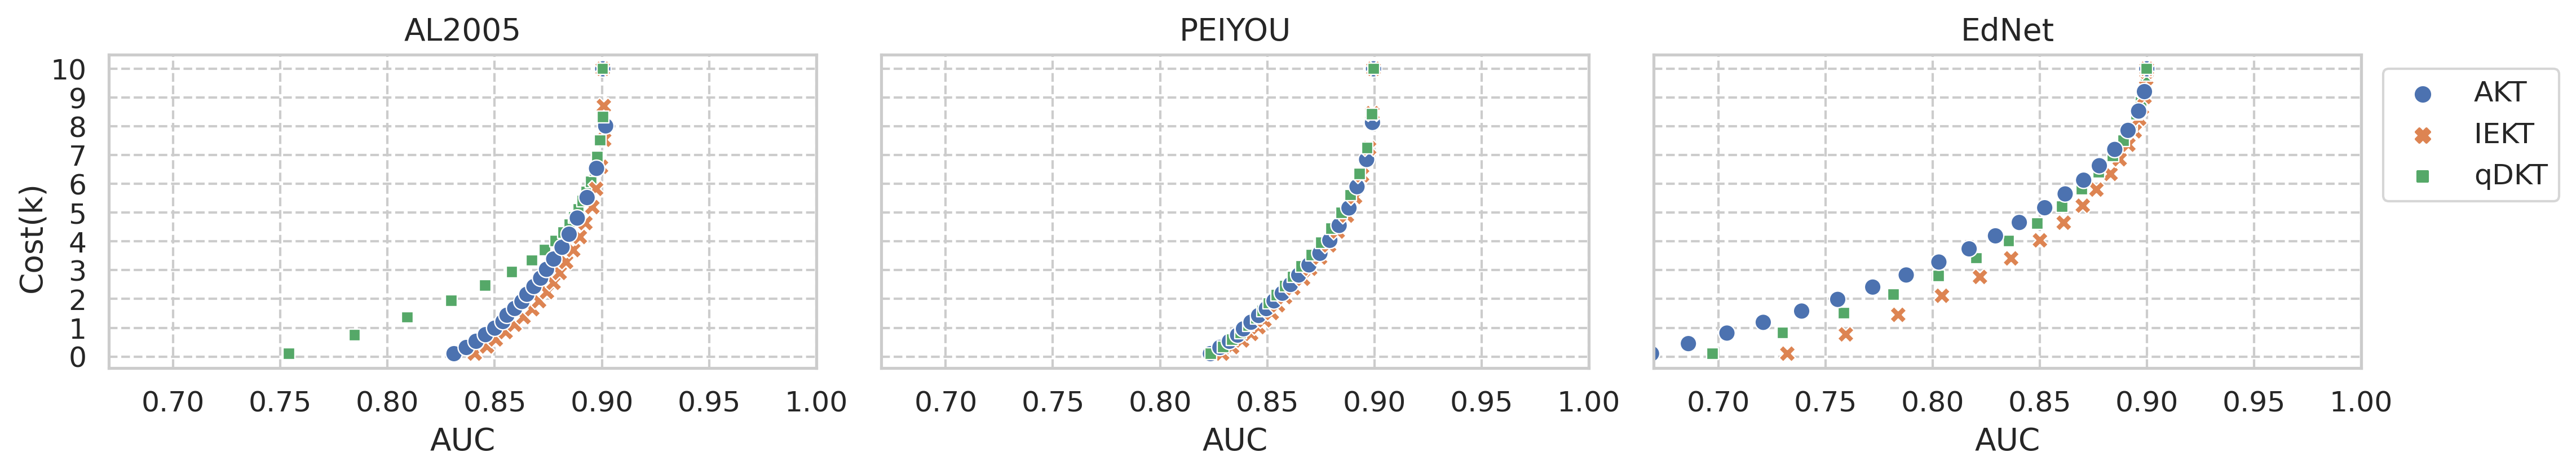

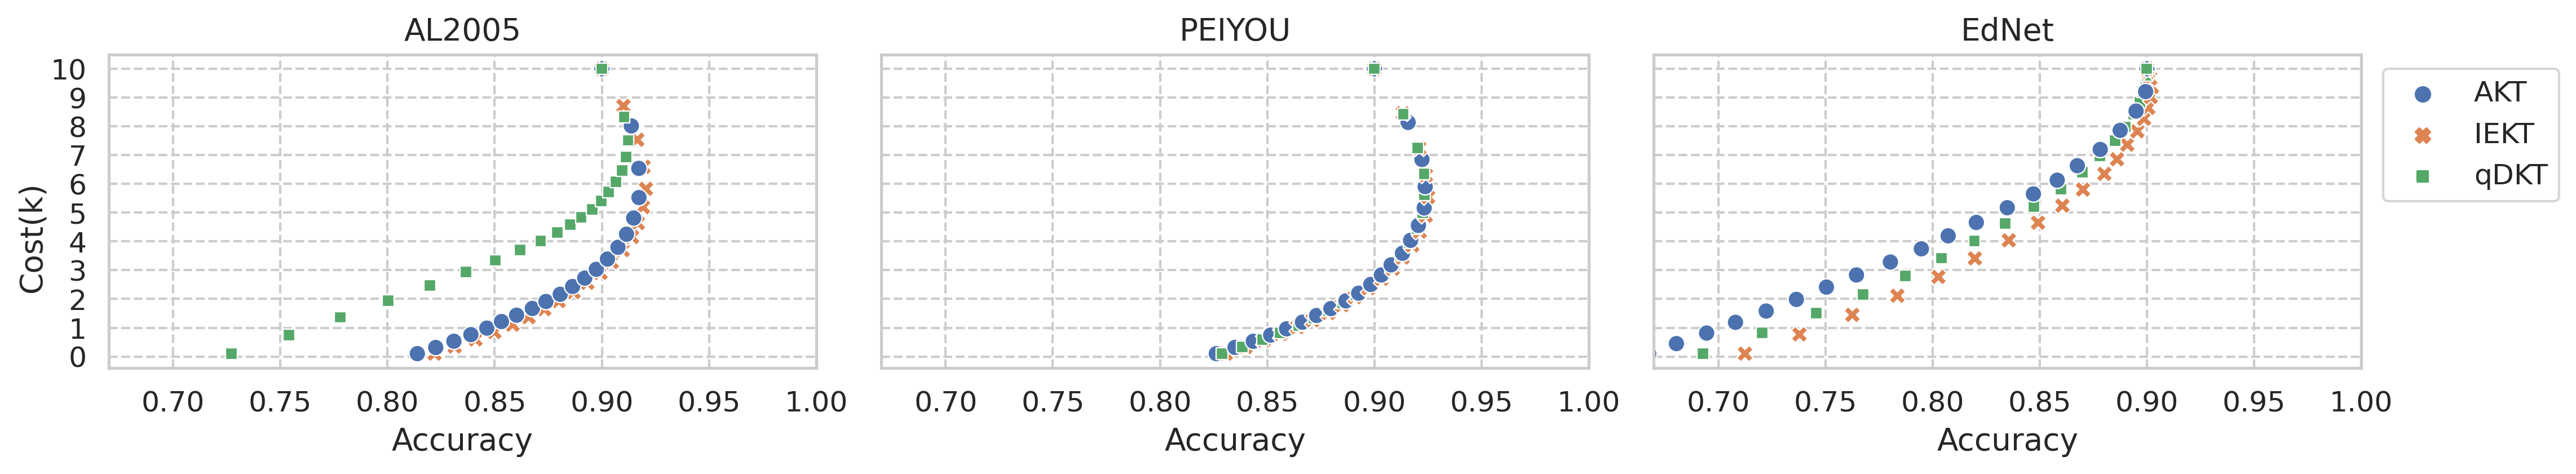

In [69]:
for alloc_mode in ['S', 'A']:
    for metric in ['auc', 'acc']:
        fig, ax = plt.subplots(1, len(sub_dataset_list), figsize=(
            15, 3), sharey=True, sharex=True)
        i = 0
        for i in range(len(sub_dataset_list)):
            dataset_index = dataset_list.index(sub_dataset_list[i])
            df_plot = alloc_mode_plot_dict[alloc_mode][dataset_index]
            df_plot[df_plot['dataset'].isin(sub_dataset_list)]
            sns.scatterplot(data=df_plot, x=metric,
                            y='cost_k', hue='Model', style='Model', s=50, ax=ax[i], legend=i == len(sub_dataset_list)-1)
            ax[i].set_title(col_map[sub_dataset_list[i]])
#             ax[i].axvline(x=0.85, color='r', linestyle='-.')
            ax[i].set_xticks(np.arange(0.7, 1.01, 0.05))
            if alloc_mode == "S":
                ax[i].set_yticks(np.arange(0, 50.1, 10))
            elif alloc_mode == "A":
                ax[i].set_yticks(np.arange(0, 10.1, 1))
            ax[i].set_ylabel("")
            if metric == 'acc':
                ax[i].set_xlabel("Accuracy")
            else:
                ax[i].set_xlabel("AUC")
        plt.xlim(0.67, 1)
        plt.xlim(right=1)
        if alloc_mode == "S":
            plt.legend(bbox_to_anchor=(1, 1))
        elif alloc_mode == "A":
            plt.legend(bbox_to_anchor=(1.3, 1))
        plt.tight_layout()
    #     fig.text(0.5, 0, 'Accuracy', ha='center')
        fig.text(0, 0.5, 'Cost(k)', va='center', rotation='vertical')

        plt.savefig(
            f"data/imgs/{alloc_mode}-{metric}-cost.pdf", bbox_inches="tight")
#         print(f"{alloc_mode}-{metric}")
    #     break

In [126]:
# df_06 =  alloc_mode_plot_dict[alloc_mode][3]

In [127]:
# df_06[df_06['Model']=='AKT']

#### S/A搞在一起_部分数据集 单轴

In [14]:
df_plot.head()

dataset   tau Model alloc_mode  auto_score_cover  repeat_index  human_num  \
0   ednet  0.00   AKT          A           0.99991           4.5        0.9   
1   ednet  0.00  IEKT          A           1.00000           4.5        0.0   
2   ednet  0.00  qDKT          A           1.00000           4.5        0.0   
3   ednet  0.05   AKT          A           0.96469           4.5      353.1   
4   ednet  0.05  IEKT          A           0.93232           4.5      676.8   

      cost      acc       auc  human_acc  human_auc  model_acc  model_auc  \
0  100.891  0.66759  0.668886    0.67358   0.740142    0.66760   0.668871   
1  100.000  0.71249  0.732255    0.33796   0.500000    0.71249   0.732255   
2  100.000  0.69293  0.697308    0.33796   0.500000    0.69293   0.697308   
3  449.569  0.68051  0.686088    0.90000   0.899949    0.66760   0.668871   
4  770.032  0.73792  0.759550    0.90000   0.899949    0.71249   0.732255   

     cost_k  
0  0.100891  
1  0.100000  
2  0.100000  
3  0.449569  
4  0.770032

In [15]:
model_name_map ={
'IEKT+S': "Adv w. ours",
'IEKT+A': "Int w. ours",
'qDKT+S': "Adv w. qDKT",
'qDKT+A': "Int w. qDKT",
'AKT+S': "Adv w. AKT",
'AKT+A': "Int w. AKT"
}
# color_map = dict(zip(model_list,list(sns.color_palette(n_colors=3))))
color_map = {
'Adv w. qDKT': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
'Int w. qDKT': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
'Adv w. ours': (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
'Int w. ours': (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
'Adv w. AKT': (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
'Int w. AKT': (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
'S':(0,0, 0),
'A':(0,0, 0)  
            }
marker_map = {
'Adv w. ours': "D",
'Int w. ours': "P",
'Adv w. qDKT': "D",
'Int w. qDKT': "P",
'Adv w. AKT': "D",
'Int w. AKT': "P",
'S':"D",
'A':"P",
}
# https://matplotlib.org/stable/api/markers_api.html

In [16]:
sns.color_palette(n_colors=10)

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [17]:
sns.set_theme(context='notebook',style='whitegrid',font_scale=1.5)
sns.set_style("whitegrid", {"grid.linestyle": "--"})

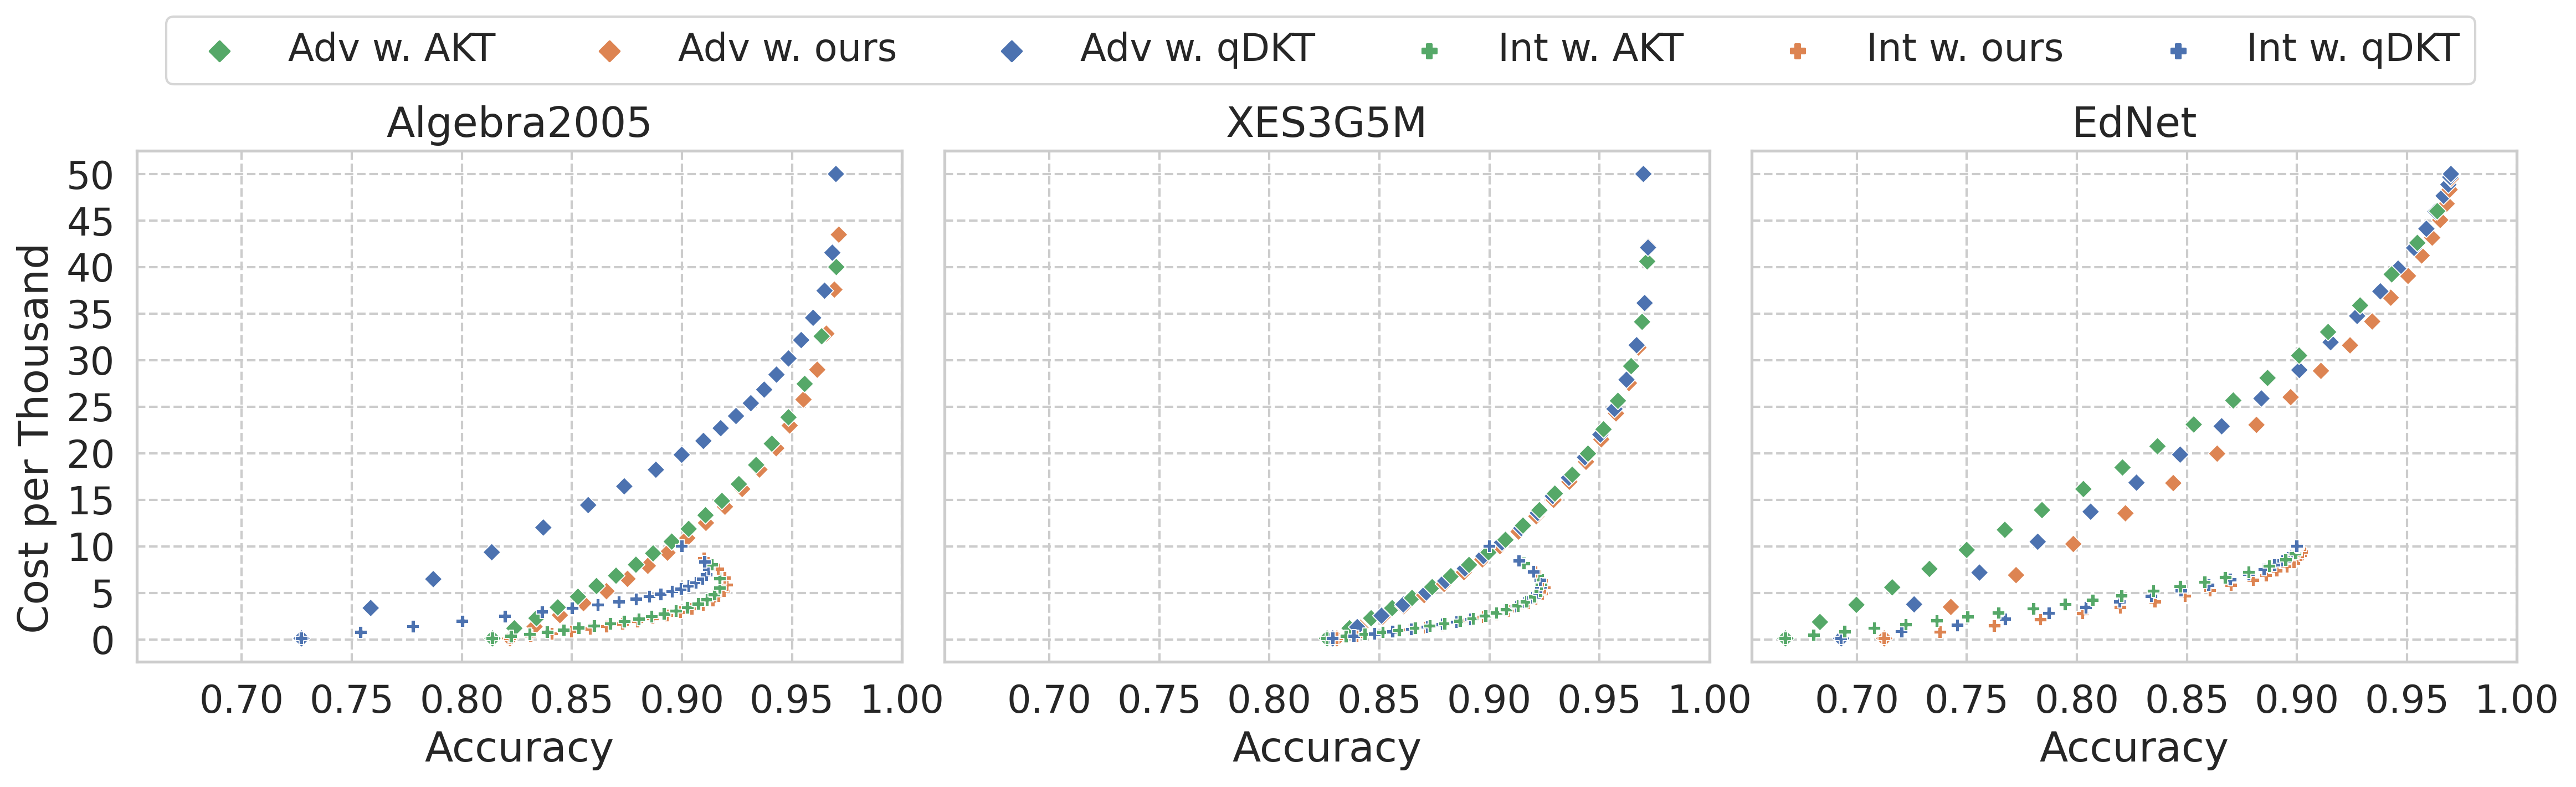

In [22]:
metric = "acc"
fig, ax = plt.subplots(1, len(sub_dataset_list), figsize=(15, 4), sharey=True, sharex=True)
i = 0

for i in range(len(sub_dataset_list)):
    dataset_index = dataset_list.index(sub_dataset_list[i])
    df_plot_s = alloc_mode_plot_dict['S'][dataset_index]
    df_plot_a = alloc_mode_plot_dict['A'][dataset_index]
    
    df_plot = pd.concat([df_plot_s,df_plot_a])
    df_plot['Model'] = df_plot['Model']+"+"+df_plot['alloc_mode']
    df_plot['Model'] = df_plot['Model'].map(model_name_map)
    df_plot[df_plot['dataset'].isin(sub_dataset_list)]

    sns.scatterplot(data=df_plot, x=metric,
                    y='cost_k', hue='Model', style='Model', s=30, ax=ax[i], legend=i == len(sub_dataset_list)-1,
                    palette = color_map,markers=marker_map
                   )
    ax[i].set_title(col_map[sub_dataset_list[i]])
    ax[i].set_xticks(np.arange(0.7, 1.01, 0.05))
    ax[i].set_yticks(np.arange(0, 50.1, 5))
    ax[i].set_xlabel("Accuracy")
    ax[i].set_ylabel("")
plt.tight_layout(pad=0)
plt.legend(bbox_to_anchor=(0.97, 1.3),ncol=6)
fig.text(-0.02, 0.5, 'Cost per Thousand', va='center', rotation='vertical')
plt.savefig(
    f"data/imgs/SA-{metric}-cost.pdf", bbox_inches="tight")

#### 2*2  S/A搞在一起_部分数据集 单轴

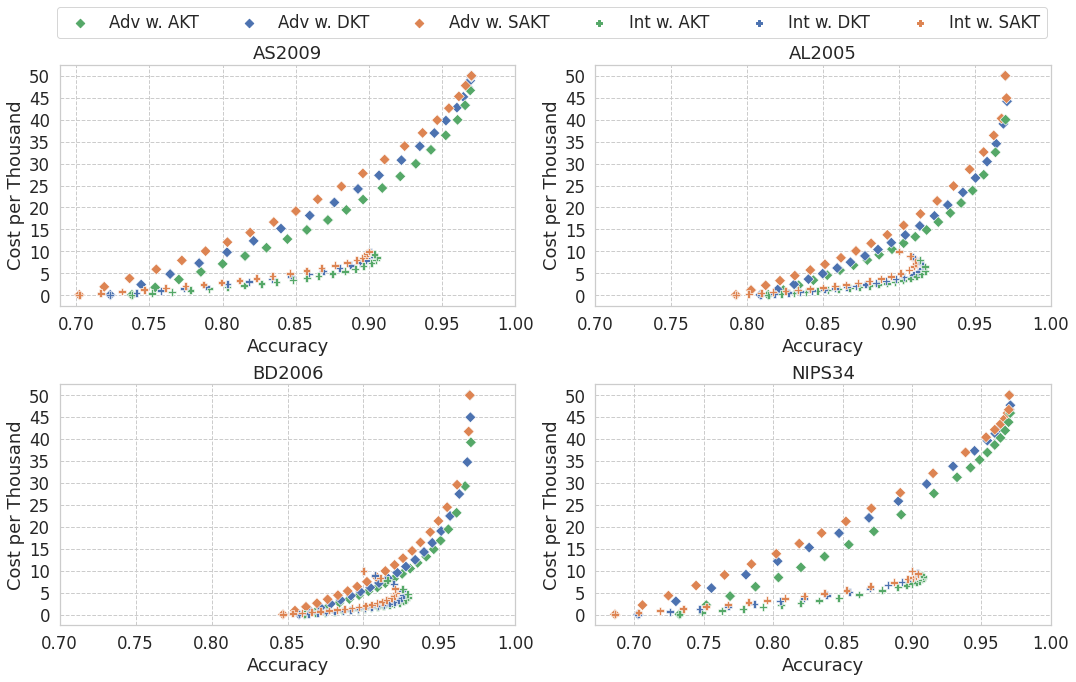

In [599]:
metric = "acc"
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(15, 9))
ax = ax.flatten()
i = 0

for i in range(len(sub_dataset_list)):
    dataset_index = dataset_list.index(sub_dataset_list[i])
    df_plot_s = alloc_mode_plot_dict['S'][dataset_index]
    df_plot_a = alloc_mode_plot_dict['A'][dataset_index]
    
    df_plot = pd.concat([df_plot_s,df_plot_a])
    df_plot['Model'] = df_plot['Model']+"+"+df_plot['alloc_mode']
    df_plot['Model'] = df_plot['Model'].map(model_name_map)
    df_plot[df_plot['dataset'].isin(sub_dataset_list)]

    sns.scatterplot(data=df_plot, x=metric,
                    y='cost_k', hue='Model', style='Model', s=60, ax=ax[i], legend=i == len(sub_dataset_list)-1,
                    palette = color_map,markers=marker_map
                   )
    ax[i].set_title(col_map[sub_dataset_list[i]])
    ax[i].set_xticks(np.arange(0.7, 1.01, 0.05))
    ax[i].set_yticks(np.arange(0, 50.1, 5))
    ax[i].set_xlabel("Accuracy")
    ax[i].set_ylabel("Cost per Thousand")
plt.tight_layout(pad=0.5)
plt.legend(bbox_to_anchor=(1.01, 2.6),ncol=6)
plt.savefig(
    f"data/imgs/4-dataset-SA-{metric}-cost.pdf", bbox_inches="tight")

#### S/A搞在一起_部分数据集 双轴

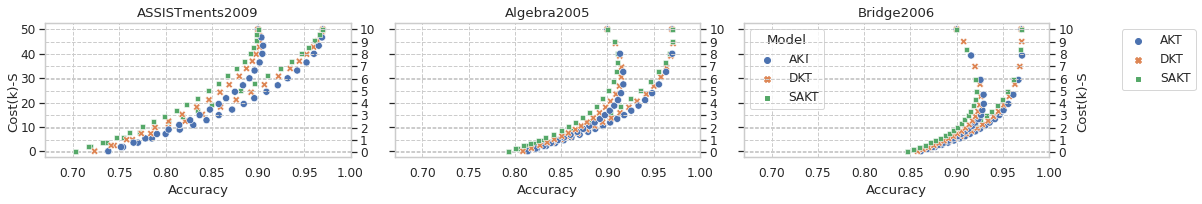

In [147]:
metric = "acc"
fig, ax = plt.subplots(1, len(sub_dataset_list), figsize=(15, 3), sharey=True, sharex=True)
for alloc_mode in ['S', 'A']:
    i = 0
    for i in range(len(sub_dataset_list)):
        dataset_index = dataset_list.index(sub_dataset_list[i])
        df_plot = alloc_mode_plot_dict[alloc_mode][dataset_index]
        df_plot[df_plot['dataset'].isin(sub_dataset_list)]
        sub_ax = ax[i]
        if alloc_mode == "A":
            sub_ax = ax[i].twinx()
        sns.scatterplot(data=df_plot, x=metric,
                        y='cost_k', hue='Model', style='Model', s=50, ax=sub_ax, legend=i == len(sub_dataset_list)-1)
        if alloc_mode == "S":
            sub_ax.set_title(col_map[sub_dataset_list[i]])
            sub_ax.set_xticks(np.arange(0.7, 1.01, 0.05))
            sub_ax.set_ylabel("")
            sub_ax.set_xlabel("Accuracy")
        else:
#             sub_ax.set_ylabel("Cost(k)-A")
            sub_ax.set_ylabel("")
        if alloc_mode == "S":
            sub_ax.set_yticks(np.arange(0, 50.1, 10))
        elif alloc_mode == "A":
            sub_ax.set_yticks(np.arange(0, 10.1, 1))
plt.xlim(0.67, 1)
plt.tight_layout(pad=1)
fig.text(0, 0.5, 'Cost(k)-S', va='center', rotation='vertical')
fig.text(0.99, 0.5, 'Cost(k)-S', va='center', rotation='vertical')
plt.legend(bbox_to_anchor=(1.5, 1))

plt.savefig(
    f"data/imgs/SA-double-ax-{metric}-cost.pdf", bbox_inches="tight")

In [38]:
!rm img.zip
!zip img.zip -r data/imgs

  adding: data/imgs/ (stored 0%)
  adding: data/imgs/.ipynb_checkpoints/ (stored 0%)
  adding: data/imgs/S-auc-cost_all_dataset.pdf (deflated 10%)
  adding: data/imgs/A-auc-cost_all_dataset.pdf (deflated 10%)
  adding: data/imgs/S-acc-cost.pdf (deflated 14%)
  adding: data/imgs/S-acc-cost_all_dataset.pdf (deflated 10%)
  adding: data/imgs/A-acc-cost.pdf (deflated 14%)
  adding: data/imgs/S-auc-cost.pdf (deflated 14%)
  adding: data/imgs/A-acc-cost_all_dataset.pdf (deflated 10%)
  adding: data/imgs/A-auc-cost.pdf (deflated 14%)


### 覆盖率 VS AUC&Cost

In [ ]:
# sns.set_theme(context='notebook',style='whitegrid',font_scale=1.1)
# sns.set_style("whitegrid", {"grid.linestyle": "--"})

#### remove cost

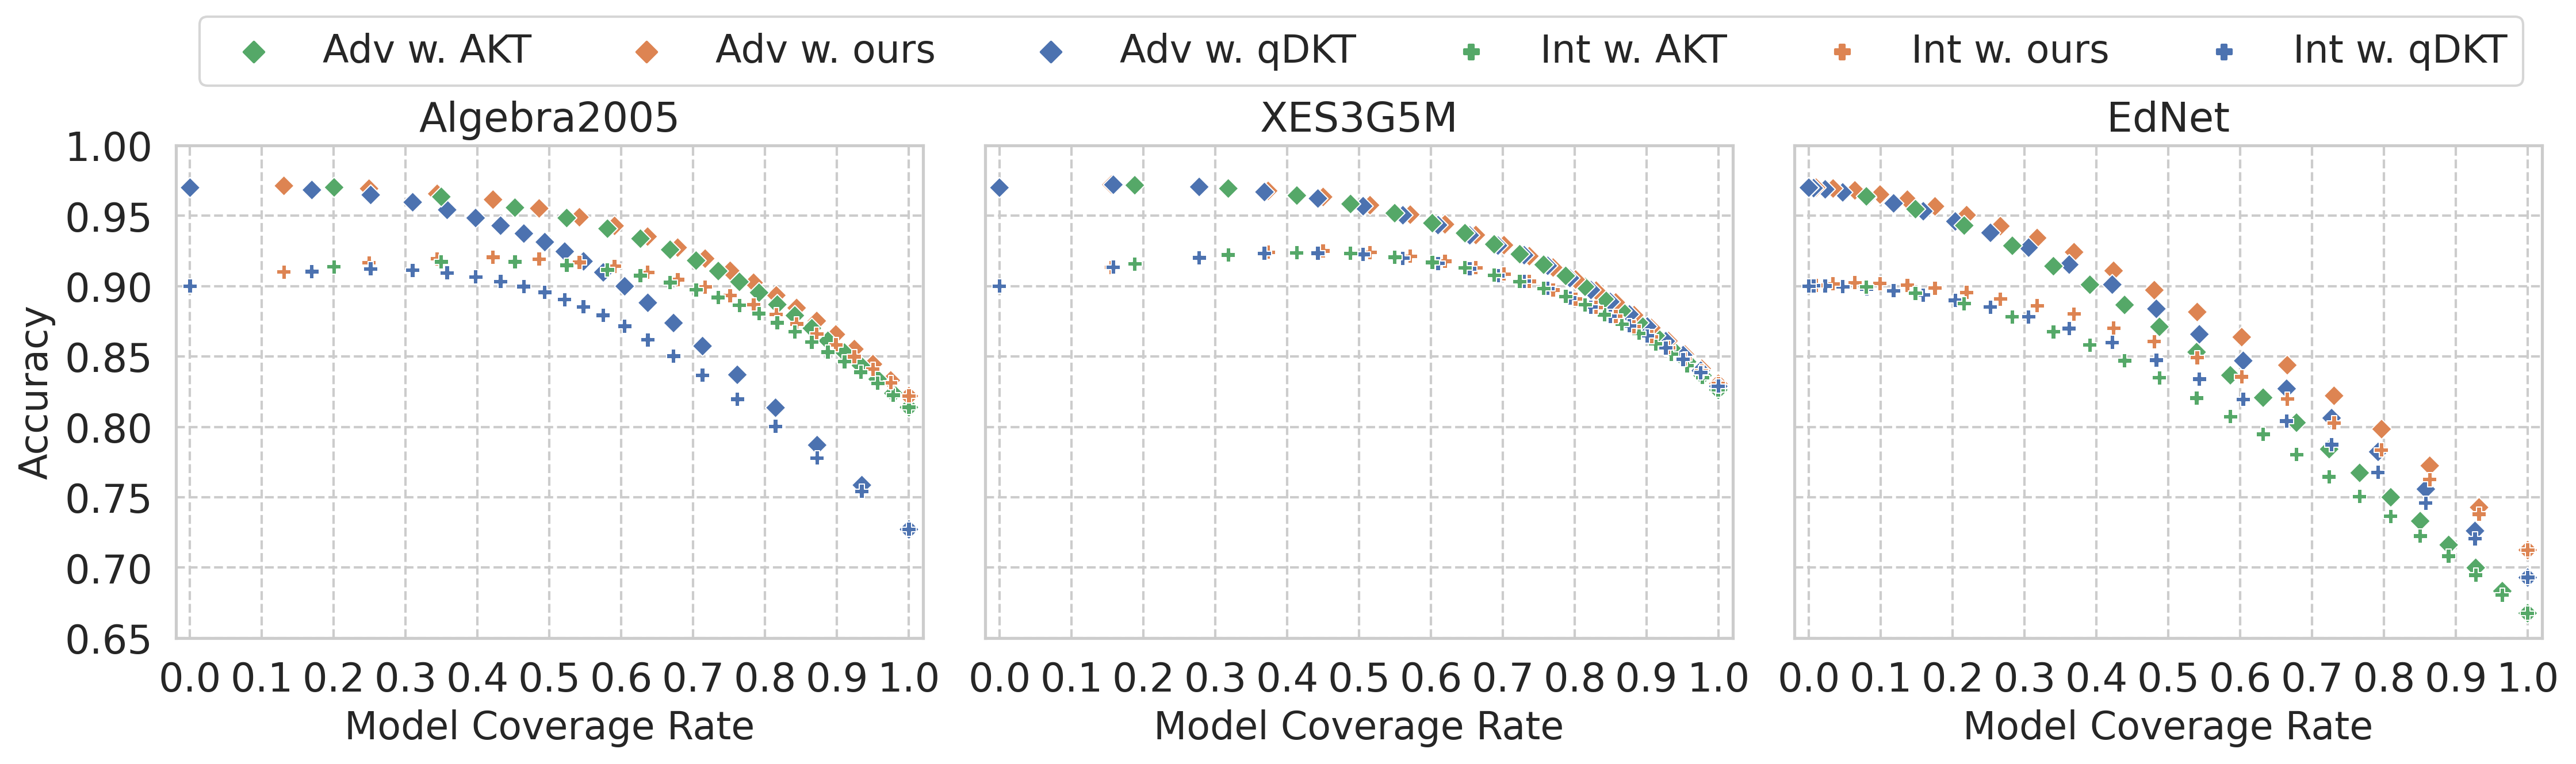

In [27]:
fig, ax = plt.subplots(1, len(sub_dataset_list), figsize=(15, 4), sharey=True, sharex=True)
i = 0

for i in range(len(sub_dataset_list)):
    dataset_index = dataset_list.index(sub_dataset_list[i])
    df_plot_s = alloc_mode_plot_dict['S'][dataset_index]
    df_plot_a = alloc_mode_plot_dict['A'][dataset_index]
    
    df_plot = pd.concat([df_plot_s,df_plot_a])
    df_plot['Model'] = df_plot['Model']+"+"+df_plot['alloc_mode']
    df_plot['Model'] = df_plot['Model'].map(model_name_map)
    df_plot[df_plot['dataset'].isin(sub_dataset_list)]

    sns.scatterplot(data=df_plot, x='auto_score_cover',
                    y='acc'
                 , hue='Model', style='Model', 
                 ax=ax[i], legend=i == len(sub_dataset_list)-1,
                    palette = color_map,markers=marker_map
                   )
    ax[i].set_title(col_map[sub_dataset_list[i]], fontsize=17)
    ax[i].set_yticks(np.arange(0.65, 1.01, 0.05))
    ax[i].set_xticks(np.arange(0, 1.01, 0.1))
    ax[i].set_xlabel("Model Coverage Rate", fontsize=16)
    # ax[i].set_xlabel("Model Prediction Coverage(%)")
    ax[i].set_ylabel("Accuracy", fontsize=16)
plt.xlim(-0.02,1.02)
plt.tight_layout(pad=0.5)
plt.legend(bbox_to_anchor=(1, 1.3),prop = {'size':16}, ncol=6)
#fig.text(-0.02, 0.5, 'Accuracy', va='center', rotation='vertical')
plt.savefig(
    f"data/imgs/SA-auto_score_cover-acc.pdf", bbox_inches="tight")

#### 2*2 remove cost

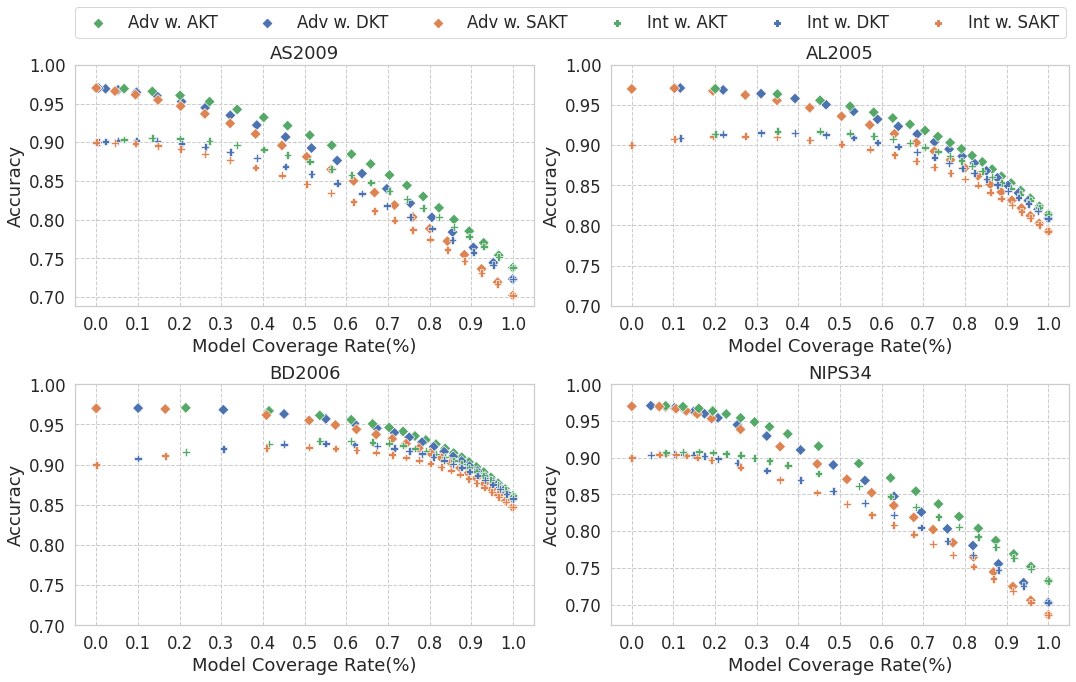

In [600]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(15, 9))
ax = ax.flatten()
i = 0
for i in range(len(sub_dataset_list)):
    dataset_index = dataset_list.index(sub_dataset_list[i])
    df_plot_s = alloc_mode_plot_dict['S'][dataset_index]
    df_plot_a = alloc_mode_plot_dict['A'][dataset_index]
    
    df_plot = pd.concat([df_plot_s,df_plot_a])
    df_plot['Model'] = df_plot['Model']+"+"+df_plot['alloc_mode']
    df_plot['Model'] = df_plot['Model'].map(model_name_map)
    df_plot[df_plot['dataset'].isin(sub_dataset_list)]

    sns.scatterplot(data=df_plot, x='auto_score_cover',
                    y='acc'
                 , hue='Model', style='Model', 
                 ax=ax[i], legend=i == len(sub_dataset_list)-1,
                    palette = color_map,markers=marker_map,
                    s=60,
                   )
    ax[i].set_title(col_map[sub_dataset_list[i]])
    ax[i].set_yticks(np.arange(0.7, 1.01, 0.05))
    ax[i].set_xticks(np.arange(0, 1.01, 0.1))
    ax[i].set_xlabel("Model Coverage Rate(%)")
    ax[i].set_ylabel("Accuracy")
plt.tight_layout(pad=0.5)
plt.legend(bbox_to_anchor=(1.01, 2.6),ncol=6)
plt.savefig(
    f"data/imgs/4-dataset-SA-auto_score_cover-acc.pdf", bbox_inches="tight")

#### keep cost

In [456]:
import matplotlib.lines as mlines

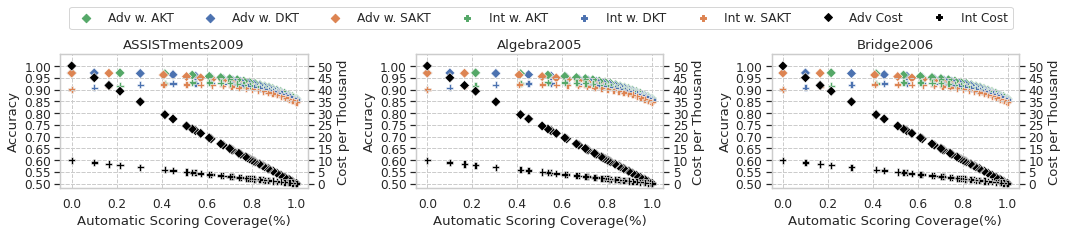

In [457]:
fig, ax = plt.subplots(1, len(sub_dataset_list),
                       figsize=(15, 3), sharey=False, sharex=True)

df_tmp = None
for plot_col in ['acc', 'cost']:
    i = 0
    for i in range(len(sub_dataset_list)):
        df_plot_s = alloc_mode_plot_dict['S'][dataset_index]
        df_plot_a = alloc_mode_plot_dict['A'][dataset_index]

        df_plot = pd.concat([df_plot_s, df_plot_a])
        df_plot['Model'] = df_plot['Model']+"+"+df_plot['alloc_mode']
        df_plot['Model'] = df_plot['Model'].map(model_name_map)
        df_plot[df_plot['dataset'].isin(sub_dataset_list)]
        sub_ax = ax[i]
        if plot_col == "acc":
            sns.scatterplot(data=df_plot, x='auto_score_cover',
                            y='acc', hue='Model', style='Model', s=50, ax=sub_ax,
                            legend=i == len(sub_dataset_list)-1, palette=color_map, markers=marker_map
                            )
        else:
            sub_ax = ax[i].twinx()
            df_plot['auto_score_cover_round'] = df_plot['auto_score_cover'].apply(
                lambda x: round(x, 2))
            df_plot = df_plot.drop_duplicates(
                ['alloc_mode', 'auto_score_cover_round'])
            sns.scatterplot(data=df_plot, x='auto_score_cover',
                            y='cost_k', hue='alloc_mode', style='alloc_mode', s=50, ax=sub_ax,
                            legend=False, palette=color_map, markers=marker_map
                            )
            df_tmp = df_plot

        sub_ax.set_xlabel("Automatic Scoring Coverage(%)")
        if plot_col == "acc":
            sub_ax.set_title(col_map[sub_dataset_list[i]])
            sub_ax.set_ylabel("Accuracy")

        else:
            sub_ax.set_ylabel("Cost per Thousand")

        if plot_col == "acc":
            sub_ax.set_yticks(np.arange(0.5, 1.05, 0.05))
            sub_ax.set_ylim(0.5-0.0198, 1.05)
        elif plot_col == "cost":
            #             sub_ax.set_yticks(np.arange(0, 50.1, 5))
            sub_ax.set_yticks(np.arange(0, 55, 5))
            sub_ax.set_ylim(-1.979, 55)
plt.tight_layout(pad=1)
handles, labels = ax[-1].get_legend_handles_labels()
cost_s_marker = mlines.Line2D([], [], color='black', marker='D',
                              label='Adv Cost',linewidth=0)
cost_a_marker = mlines.Line2D([], [], color='black', marker='P',
                              label='Int Cost',linewidth=0)
handles.extend([cost_s_marker, cost_a_marker])
labels.extend(['Adv Cost', 'Int Cost'])
ax[-1].legend(handles=handles, labels=labels,
              bbox_to_anchor=(1, 1.4), ncol=8)
plt.savefig(
    f"data/imgs/SA-auto_score_cover_add_cost-acc.pdf", bbox_inches="tight")

In [370]:
len(np.arange(0.65, 1, 0.05))

7

In [367]:
((1-0.65)/0.03-11)*0.02

0.013333333333333322

In [ ]:
==11

In [330]:
(1-0.6)/x = 11

0.03636363636363637

In [356]:
55*0.036

1.9799999999999998

In [359]:
(1.1-0.55)*0.036

0.0198

In [355]:
2/55

0.03636363636363636

In [333]:
len(np.arange(0, 55, 5))

11

In [ ]:
# fig, ax = plt.subplots(1, len(sub_dataset_list),
#                        figsize=(15, 3.3), sharey=True, sharex=True)
# i = 0

# for i in range(len(sub_dataset_list)):
#     dataset_index = dataset_list.index(sub_dataset_list[i])
#     df_plot_s = alloc_mode_plot_dict['S'][dataset_index]
#     df_plot_a = alloc_mode_plot_dict['A'][dataset_index]

#     df_plot = pd.concat([df_plot_s, df_plot_a])
#     df_plot['Model'] = df_plot['Model']+"+"+df_plot['alloc_mode']
#     df_plot['Model'] = df_plot['Model'].map(model_name_map)
#     df_plot[df_plot['dataset'].isin(sub_dataset_list)]

#     sns.scatterplot(data=df_plot, x='auto_score_cover',
#                     y='acc', hue='Model', style='Model',
#                     ax=ax[i], legend=i == len(sub_dataset_list)-1,
#                     palette=color_map, markers=marker_map
#                     )
#     ax[i].set_title(col_map[sub_dataset_list[i]])
#     ax[i].set_yticks(np.arange(0.7, 1.01, 0.05))
#     ax[i].set_xticks(np.arange(0, 1.01, 0.1))
#     ax[i].set_xlabel("Automatic Scoring Coverage(%)")
#     ax[i].set_ylabel("")
# plt.xlim(-0.02, 1.02)
# plt.tight_layout(pad=0.5)
# plt.legend(bbox_to_anchor=(0.53, 1.3), ncol=6)
# fig.text(-0.02, 0.5, 'Accuracy', va='center', rotation='vertical')
# # plt.savefig(
# #     f"data/imgs/SA-auto_score_cover-acc.pdf", bbox_inches="tight")

### min_auc VS cost

In [ ]:
e_report_list = []
for (dataset, model, human_level, fold), group in df_report.groupby(['dataset', 'model', 'alloc_mode', 'fold'], sort=False):
    min_value = round(df_report['auc'].min()-0.01, 2)
    for e in np.arange(min_value, 0.95001, 0.01):
        e = round(e, 3)
        group = group[group['auc'] >= e].sort_values("cost")
        if len(group) != 0:
            row = group.iloc[0]
            e_report = row.to_dict()
            e_report['min_auc'] = e
            e_report_list.append(e_report)

In [ ]:
df_e_report = pd.DataFrame(e_report_list)
df_e_report.shape

In [ ]:
df_e_report[:10]

In [ ]:
for dataset in dataset_list:
    for model in model_list:
        data = df_e_report[(df_e_report['model']==model)&(df_e_report['dataset']==dataset)]
        plt.figure(figsize=(10,5))
        sns.lineplot(data=data, x="min_auc", y="cost", hue="alloc_mode", style="alloc_mode", markers=markers,
                     markersize=markersize,
                     linewidth=linewidth,
                     palette=color_palette,
                    )
        plt.xlabel("Minimum AUC")
        plt.ylabel("Cost")
        sns.despine(left=False, bottom=False)  # 移除边框线
        plt.legend(bbox_to_anchor=(1, 1))
#         plt.title(f"{dataset}-{model}")
        plt.savefig(f"data/imgs/{dataset}-{model}_min_auc-cost.pdf",bbox_inches="tight")
#         break
#     break

### min_auc VS cost 限制单个成本

In [ ]:
df_report

In [ ]:
max_cost_list = np.arange(0,10.01,1)
max_cost_list

In [ ]:
max_cost_report_list = []
for (dataset, model, human_level, fold), group in df_report.groupby(['dataset', 'model', 'alloc_mode', 'fold'], sort=False):
    y_true = df_dict[f'{dataset}_dkt_0']['y_true'].values
    num_inter = len(y_true)
    group['avg_cost'] = group['cost']/num_inter
    for max_cost in max_cost_list:
        sub_group = group[group['avg_cost'] <= max_cost].sort_values("auc",ascending=False)
        if len(sub_group) != 0:
            row = sub_group.iloc[0]
            max_cost_report = row.to_dict()
            max_cost_report['max_cost'] = max_cost
            max_cost_report_list.append(max_cost_report)

In [ ]:
df_max_cost_report = pd.DataFrame(max_cost_report_list)
df_max_cost_report.shape

In [ ]:
df_max_cost_report.head()

In [ ]:
for dataset in dataset_list:
    for model in model_list:
        data = df_max_cost_report[(df_max_cost_report['model']==model)&(df_max_cost_report['dataset']==dataset)]
        plt.figure(figsize=(10,5))
        sns.lineplot(data=data, x="max_cost", y="auc", hue="alloc_mode", style="alloc_mode", markers=markers,
                     markersize=markersize,
                     linewidth=linewidth,
                     palette=color_palette,)
        plt.legend(bbox_to_anchor=(1, 1))
        sns.despine(left=False, bottom=False)  # 移除边框线
        plt.xlabel("Cost")
        plt.ylabel("AUC")
#         plt.title(f"{dataset}-{model}")
        plt.savefig(f"data/imgs/{dataset}-{model}_max_cost-auc.pdf",bbox_inches="tight")
#         break
#     break

### min_auc VS cost 限制总成本

In [ ]:
df_report

In [ ]:
dataset_max_cost_list = {"peiyou":[1e6,1.5e6,1e7,1.5e7,1e8],"assist2009":[1e4,1.5e4,1e5,1.5e5,1e6]}

In [ ]:
max_cost_report_list = []
for (dataset, model, human_level, fold), group in df_report.groupby(['dataset', 'model', 'alloc_mode', 'fold'], sort=False):
    y_true = df_dict[f'{dataset}_dkt_0']['y_true'].values
    max_cost_list = dataset_max_cost_list[dataset]
    for max_cost in max_cost_list:
        sub_group = group[group['cost'] <= max_cost].sort_values("auc",ascending=False)
        if len(sub_group) != 0:
            row = sub_group.iloc[0]
            max_cost_report = row.to_dict()
            max_cost_report['max_cost'] = max_cost
            max_cost_report_list.append(max_cost_report)

In [ ]:
df_max_cost_report = pd.DataFrame(max_cost_report_list)
df_max_cost_report.shape

In [ ]:
df_max_cost_report

In [ ]:
for dataset in dataset_list:
    for model in model_list:
        data = df_max_cost_report[(df_max_cost_report['model']==model)&(df_max_cost_report['dataset']==dataset)]
        plt.figure(figsize=(10,5))
        sns.lineplot(data=data, x="max_cost", y="auc", hue="alloc_mode",
                     markers=markers,
                     markersize=markersize,
                     linewidth=linewidth,
                     palette=color_palette,
                     style="alloc_mode",)
        plt.legend(bbox_to_anchor=(1, 1))
        sns.despine(left=False, bottom=False)  # 移除边框线
        plt.xlabel("Cost")
        plt.ylabel("AUC")
#         plt.title(f"{dataset}-{model}")
        plt.savefig(f"data/imgs/{dataset}-{model}_max_total_cost-auc.pdf",bbox_inches="tight")
#         break
#     break

In [ ]:
df_max_cost_report['alloc_mode'].unique()